# Splines

- GLM assumption: $g(E[Y|X])= X\beta$, is a linear function of $X$
- This is probably almost never the case
- Why ever assume linearity?
    - Simplicity
    - Interpretability
    - Minimal risk of overfitting
    - First-order Taylor approximation of true $E[Y|X]=f(X)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
import seaborn as sns
%matplotlib inline

In [2]:
# true regression function
def f(x):
    return(2*np.square(x)-50)

n = 500 # sample size
x = np.sort(np.random.uniform(low=0, high=10, size=n))
y = f(x)+np.random.normal(0, 10, n)
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     5313.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          7.72e-268
Time:                        16:14:57   Log-Likelihood:                -2158.9
No. Observations:                 500   AIC:                             4322.
Df Residuals:                     498   BIC:                             4330.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -83.2336      1.586    -52.470      0.000     -86.350     -80.117
x1            20.0334      0.275     72.889      0.000      19.493      20.573
==============================================================================
Omnibus:                       23.058   Durbin-Watson:                   0.639
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.565
Skew:                           0.247   Prob(JB):                      0.00113
Kurtosis:                       2.362   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

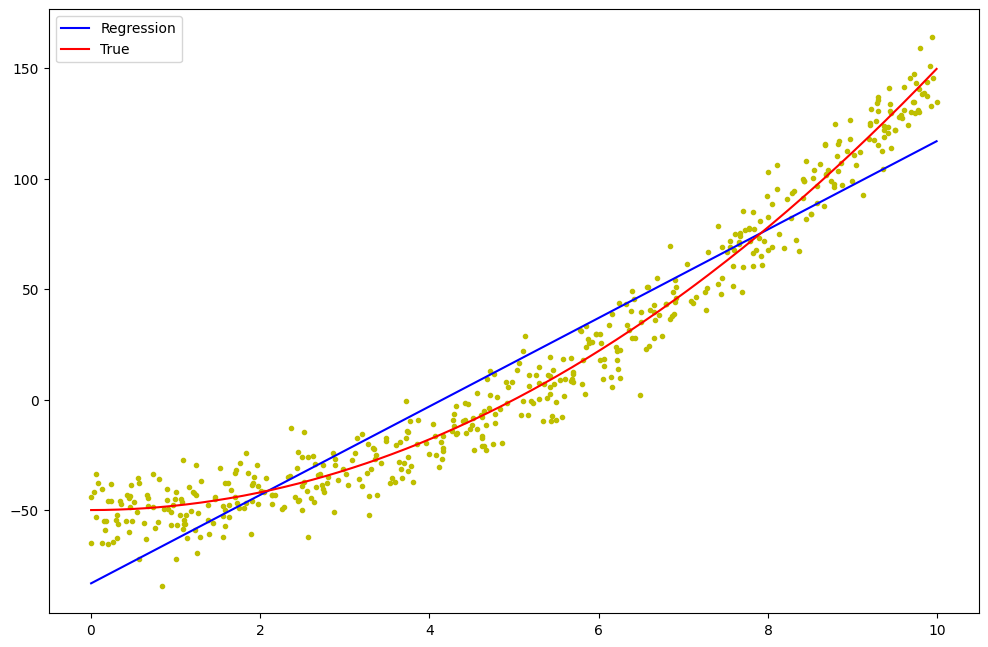

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(x,y,'.y')
plt.plot(x, x*results.params[1]+results.params[0], '-b',
         label='Regression')
plt.plot(x, f(x), '-r', label='True')
plt.legend();

- Clear that fit is not perfect
- But, it could still be helpful, depending on setting
- Easy to interpret: on average, for each unit increase in x, there is a 20 unit increase in y
- If prediction is the primary objective, this model would not be ideal
- Because this looks quadratic, we could transform x to reflect this
- Including an $x^2$ in the data will improve fit

### Case Study: South African Heart Disease

- Subset of Coronary Risk-Factor Study (CORIS) baseline survey from 1983
- Data collected in 3 rural areas of the Western Cape, South Africa
- Aim: Establish intensity of ischemic heart disease risk factors
- Note: Western Cape is a high-incidence region
- Data: White males between age 15 and 64
- Outcome: myocardial infarction (MI) at time of survey (prevalence 5.1%)
- Why not use proportional hazards regression here?

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

Data dictionary:

- **sbp:** systolic blood pressure
- **tobacco:** cumulative tobacco (kg)
- **ldl:** low density lipoprotein cholesterol
- **famhist:** family history of heart disease (Present, Absent)
- **obesity:** body mass index (bmi)
- **age:** age at onset
- **chd:** response, coronary heart disease

**Goal:** For this task, our primary objective is prediction (not inference), but we want to be able to interpret the model as well

In [4]:
url = 'https://web.stanford.edu/~hastie/ElemStatLearn//datasets/SAheart.data'
dat = pd.read_csv(url)
dat = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age', 'chd']]
print(dat.shape)
dat.head()

(462, 7)


,sbp,tobacco,ldl,famhist,obesity,age,chd
0,160,12.00,5.73,Present,25.30,52,1
1,144,0.01,4.41,Absent,28.87,63,1
2,118,0.08,3.48,Present,29.14,46,0
3,170,7.50,6.41,Present,31.99,58,1
4,134,13.60,3.50,Present,25.99,49,1


In [5]:
dat.describe().round(2)

,sbp,tobacco,ldl,obesity,age,chd
count,462.00,462.00,462.00,462.00,462.00,462.00
mean,138.33,3.64,4.74,26.04,42.82,0.35
std,20.50,4.59,2.07,4.21,14.61,0.48
min,101.00,0.00,0.98,14.70,15.00,0.00
25%,124.00,0.05,3.28,22.98,31.00,0.00
50%,134.00,2.00,4.34,25.80,45.00,0.00
75%,148.00,5.50,5.79,28.50,55.00,1.00
max,218.00,31.20,15.33,46.58,64.00,1.00


- Note: `describe` by default only looks at numeric variables
- Must also look at non-numeric variables as well

In [6]:
print(dat.dtypes)
dat.describe(include='object')

sbp          int64
tobacco    float64
ldl        float64
famhist     object
obesity    float64
age          int64
chd          int64
dtype: object


,famhist
count,462
unique,2
top,Absent
freq,270


- Exploring data
- `seaborn` has some nice exploratory data visualization methods

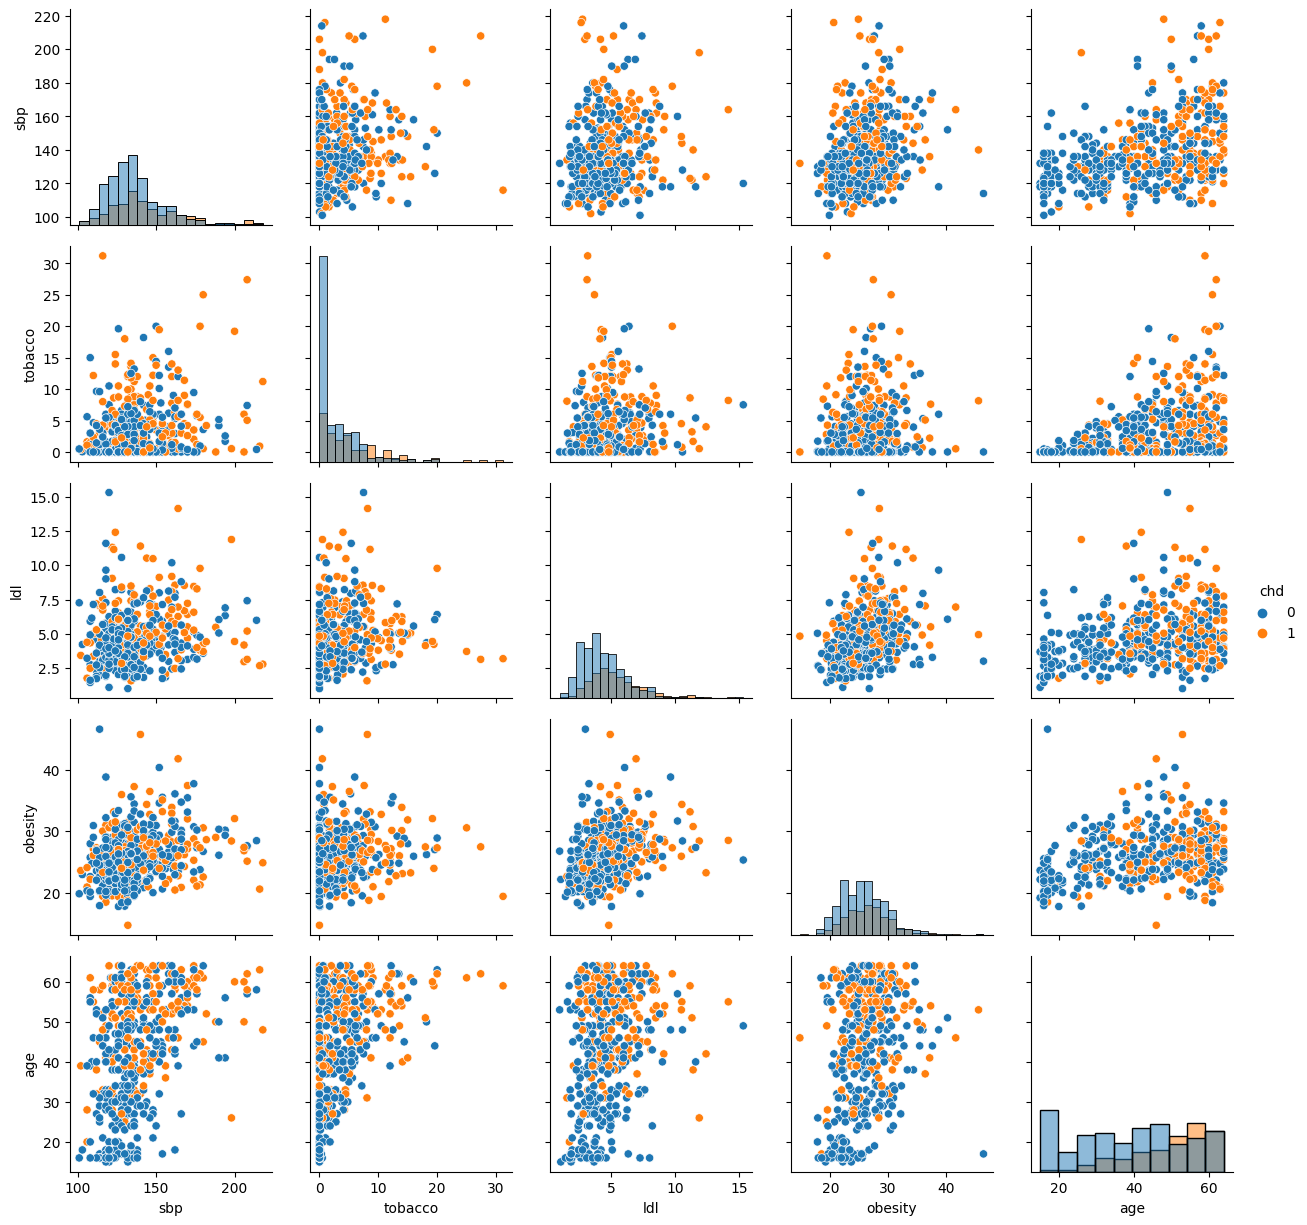

In [7]:
g = sns.PairGrid(dat, hue="chd")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

- **Violin** plots can be more helpful by showing the densities more clearly
- This can be helpful for bimodal densities

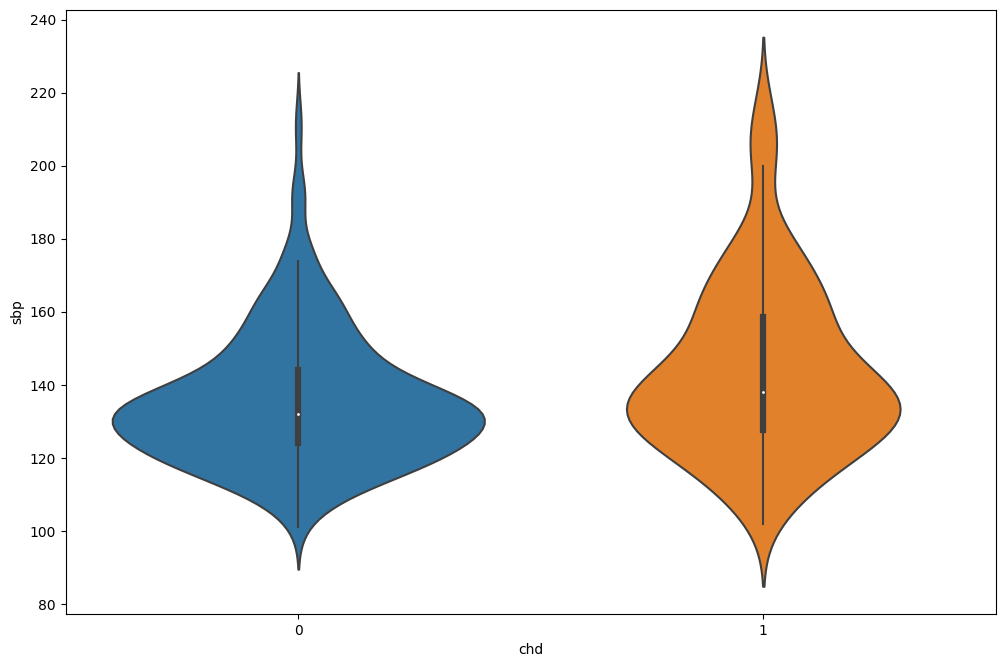

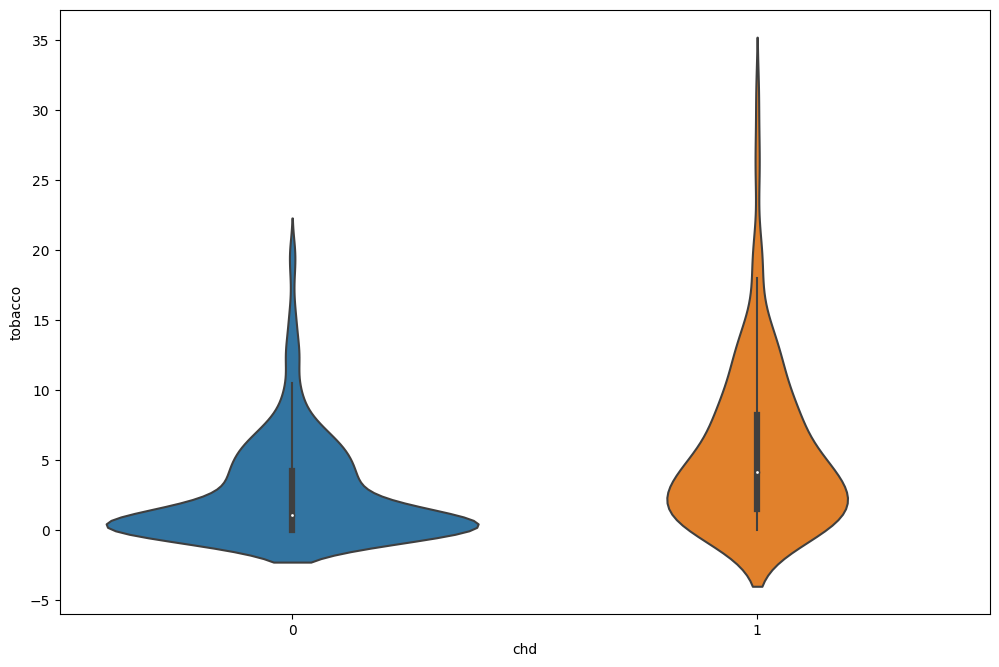

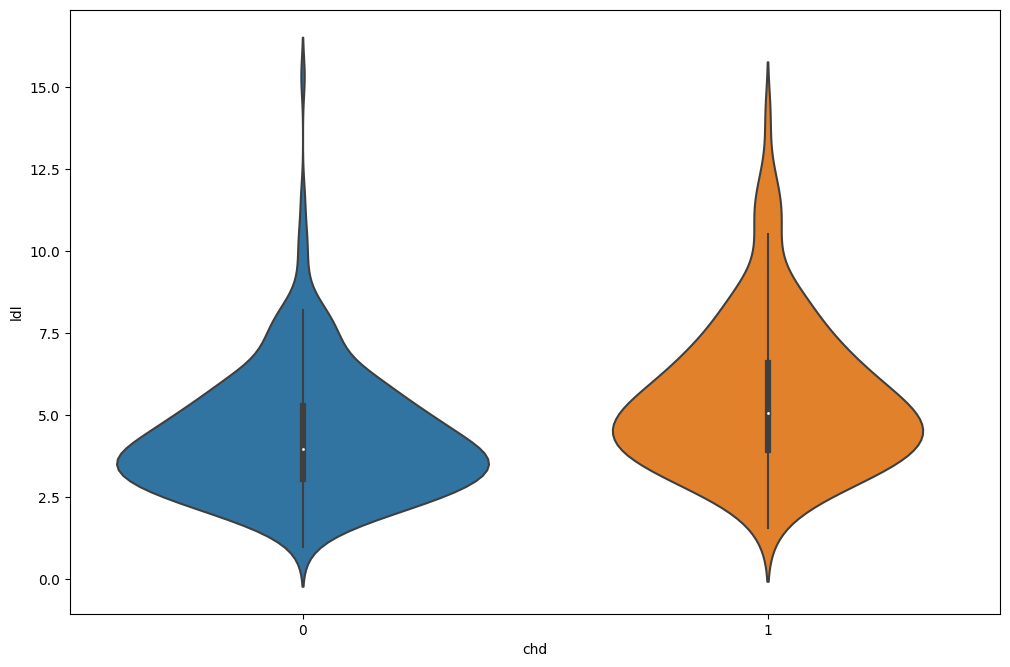

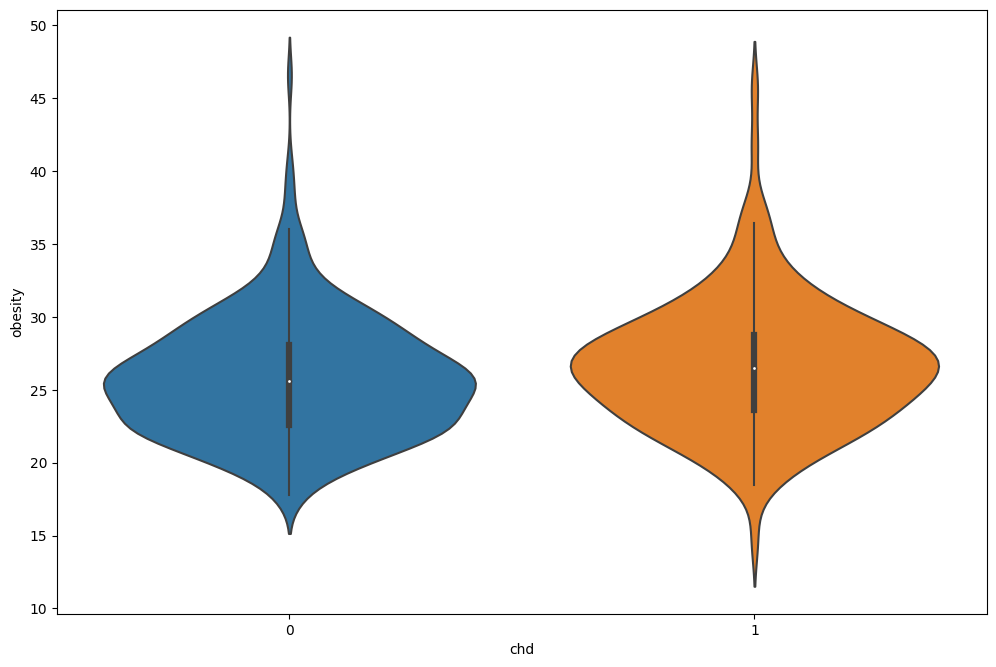

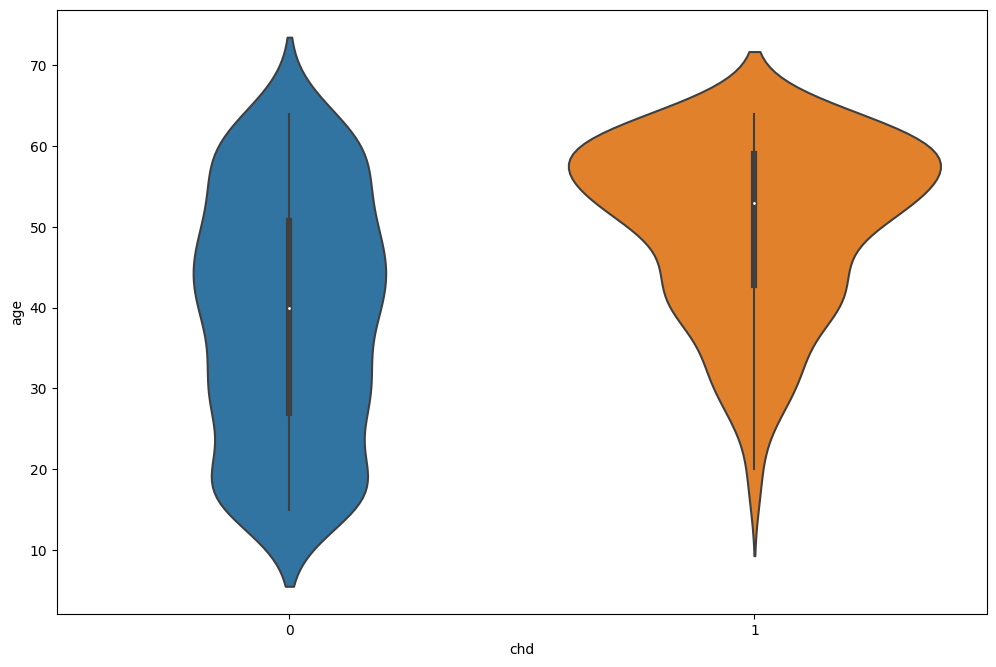

In [8]:
for var in dat.drop(columns=['chd', 'famhist']).columns:
    plt.figure()
    sns.violinplot(x='chd', y=var, data=dat)

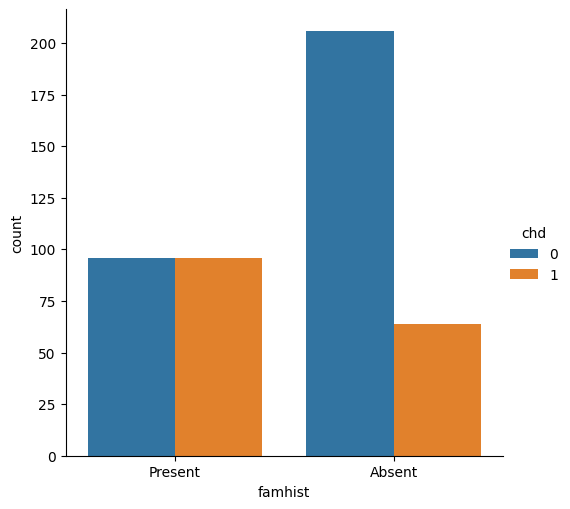

In [9]:
sns.catplot(x='famhist', hue='chd', kind='count', data=dat);

### Modeling
- Note: `statsmodels` module outcome variable and design matrix can only include numeric variables
- We can either 
    - use formula that indicates that a variable is categorical
    - manually create dummy variables for categorical data

- Using an R-style formula with `from_formula`
    - Reference: `C` operator converts numeric categorical variables to dummies

In [10]:
fml = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'
results = sm.GLM.from_formula(
    fml, data=dat, family=sm.families.Binomial()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      455
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.60
Date:                Thu, 04 Mar 2021   Deviance:                       483.19
Time:                        16:15:05   Pearson chi2:                     458.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.1278      0.964     -4.283      0.000      -6.017      -2.239
famhist[T.Present]     0.9413      0.224      4.196      0.000       0.502       1.381
sbp                    0.0059      0.006      1.050      0.294      -0.005       0.017
tobacco                0.0802      0.026      3.117      0.002       0.030       0.131
ldl                    0.1842      0.057      3.218      0.001       0.072       0.296
obesity               -0.0345      0.029     -1.187      0.235      -0.092       0.022
age                    0.0424      0.010      4.187      0.000       0.023       0.062
======================================================================================
"""

- can also give outcome vector and design matrix as inputs
- Note: using `Logit` this time

In [11]:
exog = dat.drop(columns='chd')
exog = sm.add_constant(exog)
exog['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)
results = sm.Logit(dat.chd, exog).fit()
results.summary()
results.aic

Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6


497.19253618822677

### Backward-Stepwise Selection
- When prediction is a model goal, including all variables will add random noise to the model
- To avoid this, we perform model selection
- Idea: Remove one variable at a time based on a fit metric (AIC, deviance, BIC, etc)
- Note: Categorical variables with more that two levels are usually split into multiple dummy variables, usually we will want to include or exclude the entire categorical variable.  Stepwise selection can be tricky in this setting
- Algorithm:
    - Compute fit metric for each model removing one variable
    - Chose model with best fit
    - Continue until removing variable no longer improves fit
- Coding note: remember DRY (don't repeat your self)
- Because we will be doing this multiple times, write a function

In [12]:
def back_step(response, exog):
    '''
    Input: response vector, independent (exogenous) variables
    Output: Table of variable removed and corresponding model AIC
    '''
    model_aic = pd.DataFrame(columns=['removed', 'aic'])
    for var in exog.columns:
        inputs = exog.drop(columns=var)
        results = sm.Logit(response, inputs).fit(disp=0)
        aic = results.aic
        model_aic = model_aic.append(
            {'removed': var, 'aic': aic}, ignore_index=True)
    return(model_aic)

back_step(dat.chd, exog)

,removed,aic
0,const,514.220318
1,sbp,496.296748
2,tobacco,505.615194
3,ldl,506.119335
4,famhist,513.067718
5,obesity,496.628362
6,age,513.544698


- Note: Remember that for `statsmodels`, smaller AIC is better
- Should remove `sbp`

In [13]:
back_step(dat.chd, exog.drop(columns='sbp'))

,removed,aic
0,const,515.739097
1,tobacco,504.987650
2,ldl,505.362547
3,famhist,511.931696
4,obesity,495.443861
5,age,517.072595


In [14]:
back_step(dat.chd, exog.drop(columns=['sbp', 'obesity']))

,removed,aic
0,const,595.221755
1,tobacco,504.180276
2,ldl,503.385399
3,famhist,510.824682
4,age,515.242535


- AIC for all of these models greater than 495.44
- Removing any more variables will worsen fit
- Important: standard errors, p-values no longer valid
- Parameters can be interpreted but not CIs

In [15]:
input_dat = exog.drop(columns=['sbp', 'obesity'])
back_step_results = sm.Logit(dat.chd, input_dat).fit(disp=0)
back_step_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.1856
Time:                        16:15:05   Log-Likelihood:                -242.72
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 5.251e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2043      0.498     -8.436      0.000      -5.181      -3.228
tobacco        0.0807      0.026      3.163      0.002       0.031       0.131
ldl            0.1676      0.054      3.093      0.002       0.061       0.274
famhist        0.9241      0.223      4.141      0.000       0.487       1.362
age            0.0440      0.010      4.520      0.000       0.025       0.063
==============================================================================
"""

- These coefficients are not helpful
- exponentiate the coefficients to make them more interpretable

In [16]:
back_step_results.params.apply(np.exp)

const      0.014932
tobacco    1.084046
ldl        1.182445
famhist    2.519642
age        1.045027
dtype: float64

- interpretation:
    - Compared to someone without a family history of coronary heart disease (CHD), an individual with family history of CHD, is 2.5 times more likely to experience CHD, on average
    - For each year increase in age, an individual is, on average, 1.05 times more likely to experience CHD compared to the previous year
    - again, we cannot use p-values here
- *Post-selection inference* is an active area of research
- If inference is important, you can split the data:
     - fit the model on one split
     - show results with other using model from first split
- Notice that this is the same model we would have arrived at if we had removed insignificant variables from first, full model
- This is not always the case, why?

### Beyond Linearity with Regression Spline Models

- Most of the time, a simple transformation will not be sufficient
- Can be difficult to visualize necessary transformations (logistic regression for example)
- Spline models can make this easier
- Splines maintain a balance between fit and interpretability 
- Splines are piece-wise function, like this
$$
g(x) = \begin{cases}
g_1(x) \qquad x<\xi_1 \\
g_2(x) \qquad \xi_1\leq x < \xi_2 \\
g_3(x) \qquad \xi_3 < x
\end{cases}
$$
- Note: $\xi_1, \xi_2, \xi_3$ are called knots
- For regression, could transform $x$ into 3 variables based on region
$$
\begin{align*}
h_1(x) &= I(x<\xi_1) \\
h_2(x) &= I(\xi_1\leq x < \xi_2),\\
h_3(x) &= I(\xi_3 < x)
\end{align*}
$$
- Note: $h_1, h_2, h_3$ are called basis functions
- We could use this model
$$
g(E[Y|X]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x)
$$
- Why might this not be ideal?
- What would give give us?
$$
g(E[Y|X=x]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x) +
\beta_4 h_1(x)x + \beta_5 h_2(x)x + \beta_6 h_3(x)x
$$
- What about these transformations
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= (x-\xi_1)_+ \\
h_4(x) &= (x-\xi_2)_+
\end{align*}
$$
where
$$(x)_+ =  \begin{cases}
x \qquad x>0 \\
0 \qquad x\leq 0
\end{cases}$$
- Model:
$$
g(E[Y|X=x]) = \sum_{m=1}^4 \beta_m h_m(x)
$$

![](./linearSplinesESL.png)

Image from Elements of Statistical Learning

- It's common to prefer smooth functions over linear splines

- Lower right panel: *cubic spline* has continuous with continuous first and second derivatives at the knots
- It is not difficult to show that these basis function ensure all continuity constraints
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= x^2 \\
h_4(x) &= x^3 \\
h_5(x) &= (x-\xi_1)_+^3 \\
h_6(x) &= (x-\xi_2)_+^3
\end{align*}
$$
- Parameter count: $(\text{3 regions})\times(\text{4 parameters per region})-(\text{2 knots})\times(\text{3 constraints per knot})=6$
- Higher-order splines?
    - Thought that cubic splines are the lowest-order splines where human eye cannot detect knots
    - Could you find knots if they weren't indicated?
    - Higher order splines are not frequently used in practice
    - Many parameters: must choose order of spline, number of knots and placement
    
![](./cubicSplinesESL.png)

Image from Elements of Statistical Learning



In [17]:
def knot_placement(var, num):
    '''
    input: 
        var: variable as numpy series
        num: number of knots
    output: list of knot placed at quantile locations
    '''
    quants = [(x+1)/(num+1) for x in range(num)]
    return(var.quantile(quants).tolist())

def make_linear_splines(var, knot_locs):
    '''return dataframe for continuous, linear basis'''
    sp_dat = pd.DataFrame(var)
    sp_dat = sm.add_constant(sp_dat)
    for knot in knot_locs:
        knot_name = var.name + "_" +str(int(np.round(knot)))
        sp_dat[knot_name] = var.apply(lambda x: (x-knot)*(x>knot))
    return(sp_dat)

k_locs = knot_placement(dat['age'], 5)
print(k_locs)
lin_age = make_linear_splines(dat['age'], k_locs)
lin_age.head(10)

[27.0, 38.0, 45.0, 52.33333333333326, 59.0]


,const,age,age_27,age_38,age_45,age_52,age_59
0,1.0,52,25.0,14.0,7.0,-0.000000,-0.0
1,1.0,63,36.0,25.0,18.0,10.666667,4.0
2,1.0,46,19.0,8.0,1.0,-0.000000,-0.0
3,1.0,58,31.0,20.0,13.0,5.666667,-0.0
4,1.0,49,22.0,11.0,4.0,-0.000000,-0.0
5,1.0,45,18.0,7.0,0.0,-0.000000,-0.0
6,1.0,38,11.0,0.0,-0.0,-0.000000,-0.0
7,1.0,58,31.0,20.0,13.0,5.666667,-0.0
8,1.0,29,2.0,-0.0,-0.0,-0.000000,-0.0
9,1.0,53,26.0,15.0,8.0,0.666667,-0.0


In [18]:
results = sm.Logit(dat.chd, lin_age).fit()
print(results.aic)
results.summary()

Optimization terminated successfully.
         Current function value: 0.560354
         Iterations 8
531.7670604993787


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      455
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.1314
Time:                        16:15:05   Log-Likelihood:                -258.88
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 7.860e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8038      2.340     -2.908      0.004     -11.389      -2.218
age            0.1893      0.094      2.017      0.044       0.005       0.373
age_27        -0.0938      0.128     -0.732      0.464      -0.345       0.157
age_38        -0.1396      0.116     -1.208      0.227      -0.366       0.087
age_45         0.1931      0.130      1.486      0.137      -0.062       0.448
age_52        -0.1312      0.126     -1.045      0.296      -0.377       0.115
age_59        -0.0536      0.164     -0.326      0.744      -0.376       0.269
==============================================================================
"""

In [19]:
back_step(dat.chd, lin_age)

,removed,aic
0,const,544.358655
1,age,535.156774
2,age_27,530.323798
3,age_38,531.221126
4,age_45,532.017181
5,age_52,530.862447
6,age_59,529.873510


In [20]:
back_step(dat.chd, lin_age.drop(columns='age_59'))

,removed,aic
0,const,542.452223
1,age,533.254223
2,age_27,528.423363
3,age_38,529.395446
4,age_45,530.549569
5,age_52,530.750804


In [21]:
back_step(dat.chd, lin_age.drop(columns=['age_59', 'age_27']))

,removed,aic
0,const,569.291899
1,age,546.177514
2,age_38,531.032144
3,age_45,530.023171
4,age_52,529.504337


In [22]:
results = sm.Logit(dat.chd, lin_age.drop(
    columns=['age_59', 'age_27'])).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.561064
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.1303
Time:                        16:15:05   Log-Likelihood:                -259.21
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 5.386e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4017      1.073     -5.034      0.000      -7.505      -3.299
age            0.1282      0.033      3.874      0.000       0.063       0.193
age_38        -0.1940      0.091     -2.122      0.034      -0.373      -0.015
age_45         0.2276      0.122      1.871      0.061      -0.011       0.466
age_52        -0.1635      0.094     -1.745      0.081      -0.347       0.020
==============================================================================
"""

[38.0, 45.0, 52.33333333333326]


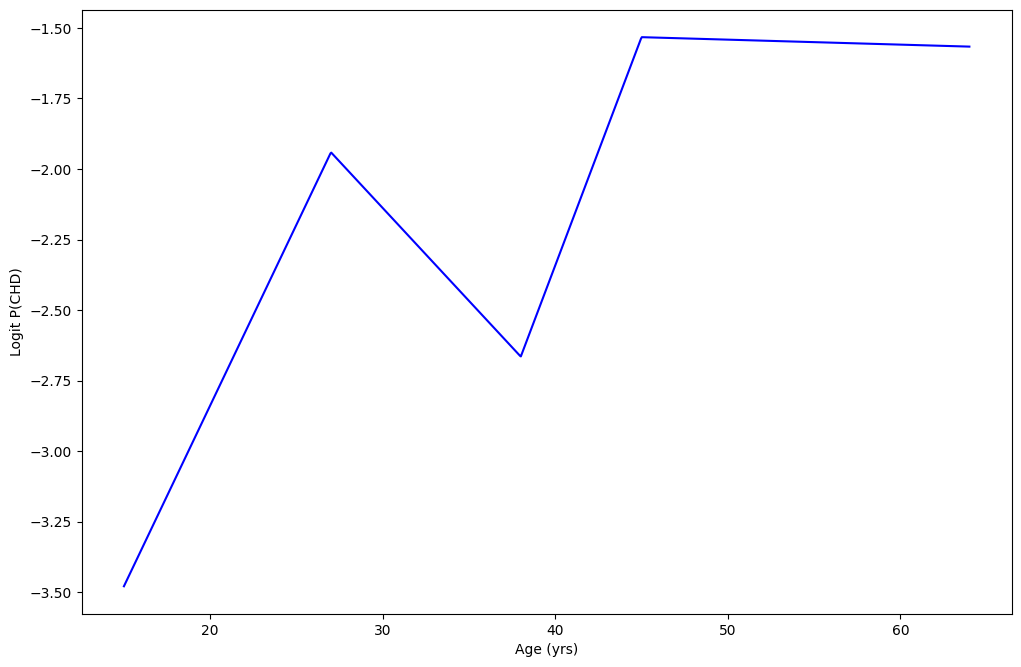

In [23]:
coefs = results.params
x_col = np.linspace(dat['age'].min(), dat['age'].max(), 1000)
locs = k_locs[1:4]
print(locs)
y = np.array([coefs[0]+coefs[1]*x+
              sum([coefs[s+2]*(x-k_locs[s])*(x>k_locs[s]) 
                   for s in range(3)]) for x in x_col])

plt.plot(x_col, y, '-b')
plt.xlabel('Age (yrs)')
plt.ylabel('Logit P(CHD)');

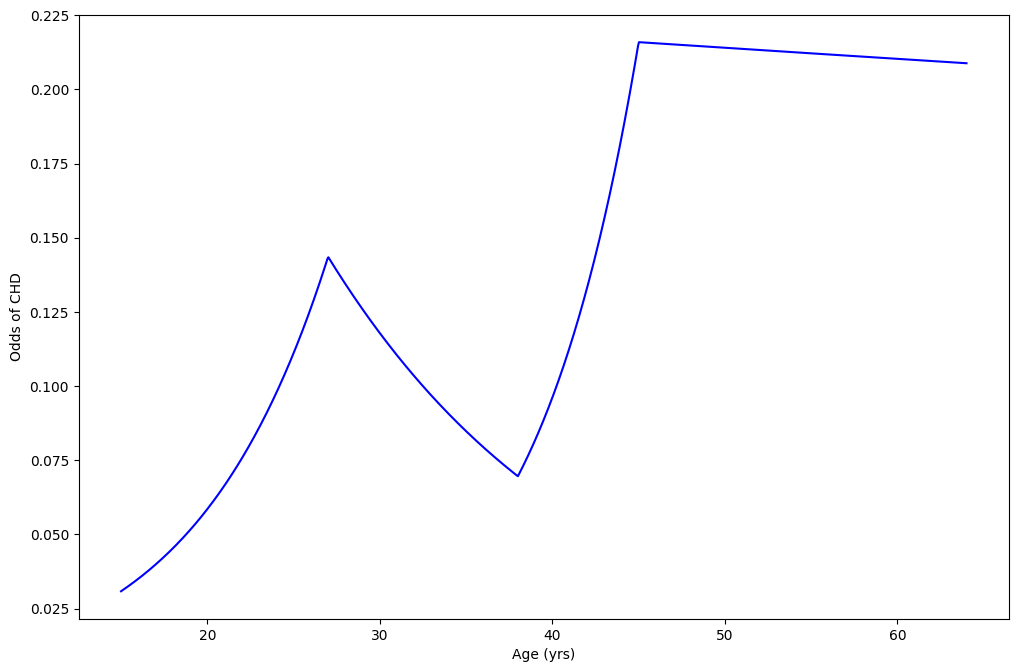

In [24]:
plt.plot(x_col, np.exp(y), '-b')
plt.xlabel('Age (yrs)')
plt.ylabel('Odds of CHD');

In [25]:
def back_select(response, exog):
    '''
    input: binary response variable and exogenous variables
    output: list of selected variables based on backward stepwise
        selection using AIC
    '''
    results = sm.Logit(response, exog).fit(disp=0)
    last_aic = results.aic
    cur_vars = list(exog.columns)
    improvement = True
    while improvement:
        aics = {}
        for var in cur_vars:
            cur_exog = exog[cur_vars].drop(columns=var)
            results = sm.Logit(response, cur_exog).fit(disp=0)
            aics[var] = results.aic
        min_var = min(aics, key=aics.get)
        cur_aic = aics[min_var]
        if cur_aic < last_aic:
            cur_vars.remove(min_var)
            last_aic = cur_aic
        else:
            improvement = False
    return(cur_vars)
        
back_select(dat.chd, lin_age)

['const', 'age', 'age_38', 'age_45', 'age_52']

In [26]:
def make_cubic_splines(var, knot_locs):
    '''return dataframe for continuous, linear basis'''
    sp_dat = pd.DataFrame(var)
    sp_dat = sm.add_constant(sp_dat)
    sp_dat[var.name+"_sqrd"] = var.apply(np.square)
    sp_dat[var.name+"_cubd"] = var.apply(lambda x: x**3)
    for knot in knot_locs:
        knot_name = var.name + "_" +str(int(np.round(knot)))
        sp_dat[knot_name] = var.apply(lambda x: (x-knot)**3*(x>knot))
    return(sp_dat)

k_locs = knot_placement(dat['age'], 3)
print(k_locs)
cube_age = make_cubic_splines(dat['age'], k_locs)
cube_age.head(10)

[31.0, 45.0, 55.0]


,const,age,age_sqrd,age_cubd,age_31,age_45,age_55
0,1.0,52,2704,140608,9261.0,343.0,-0.0
1,1.0,63,3969,250047,32768.0,5832.0,512.0
2,1.0,46,2116,97336,3375.0,1.0,-0.0
3,1.0,58,3364,195112,19683.0,2197.0,27.0
4,1.0,49,2401,117649,5832.0,64.0,-0.0
5,1.0,45,2025,91125,2744.0,0.0,-0.0
6,1.0,38,1444,54872,343.0,-0.0,-0.0
7,1.0,58,3364,195112,19683.0,2197.0,27.0
8,1.0,29,841,24389,-0.0,-0.0,-0.0
9,1.0,53,2809,148877,10648.0,512.0,-0.0


- running backward stepwise

In [27]:
keep_vars = back_select(dat.chd, cube_age)
results = sm.Logit(dat.chd, cube_age[keep_vars]).fit()
print(results.aic)
results.summary()

Optimization terminated successfully.
         Current function value: 0.561503
         Iterations 7
528.8288755657666


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.1296
Time:                        16:15:06   Log-Likelihood:                -259.41
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 6.563e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.7123      0.189     -3.763      0.000      -1.083      -0.341
age_sqrd       0.0387      0.012      3.258      0.001       0.015       0.062
age_cubd      -0.0005      0.000     -2.972      0.003      -0.001      -0.000
age_31         0.0010      0.000      2.540      0.011       0.000       0.002
age_45        -0.0009      0.000     -1.929      0.054      -0.002    1.47e-05
==============================================================================
"""

- Below is a cubic regression spline
- Note that the $y$-axis is on the Logit scale:
$$\log \frac{P(\text{CHD})}{1-P(\text{CHD})}$$

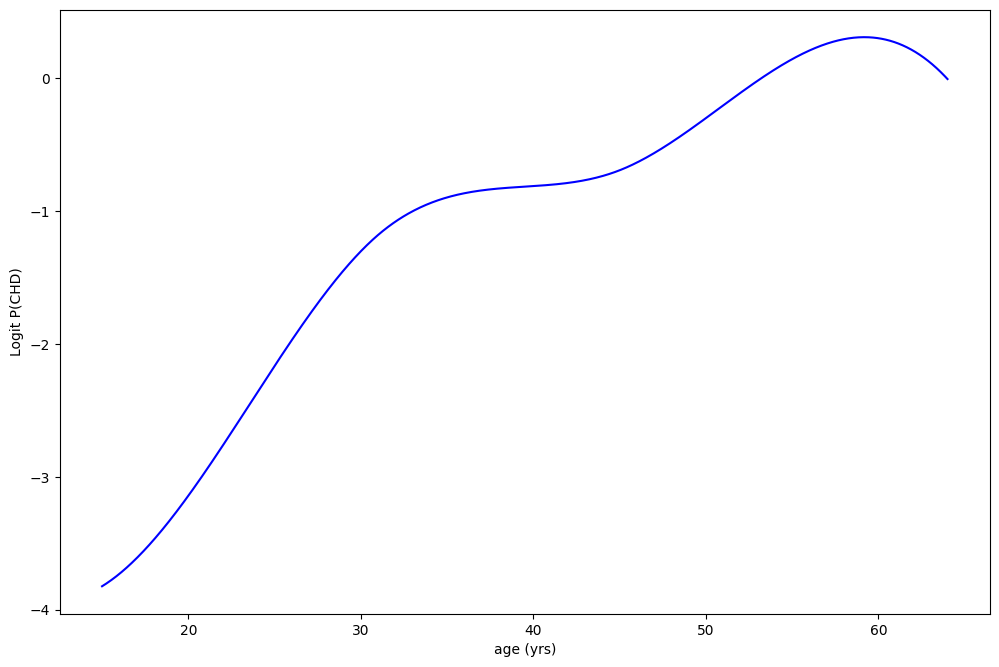

In [28]:
coefs = results.params
x_col = pd.DataFrame({'age': np.linspace(
    dat['age'].min(), dat['age'].max(), 1000)})
x_mat = make_cubic_splines(x_col['age'], k_locs)
x_mat = x_mat[keep_vars]
y = x_mat.dot(coefs)
plt.plot(x_col['age'], y, '-b')
plt.xlabel('age (yrs)')
plt.ylabel('Logit P(CHD)');

- Below is the same spline function but on the odds (or odds ratio) scale: $$\frac{P(\text{CHD})}{1-P(\text{CHD})}$$

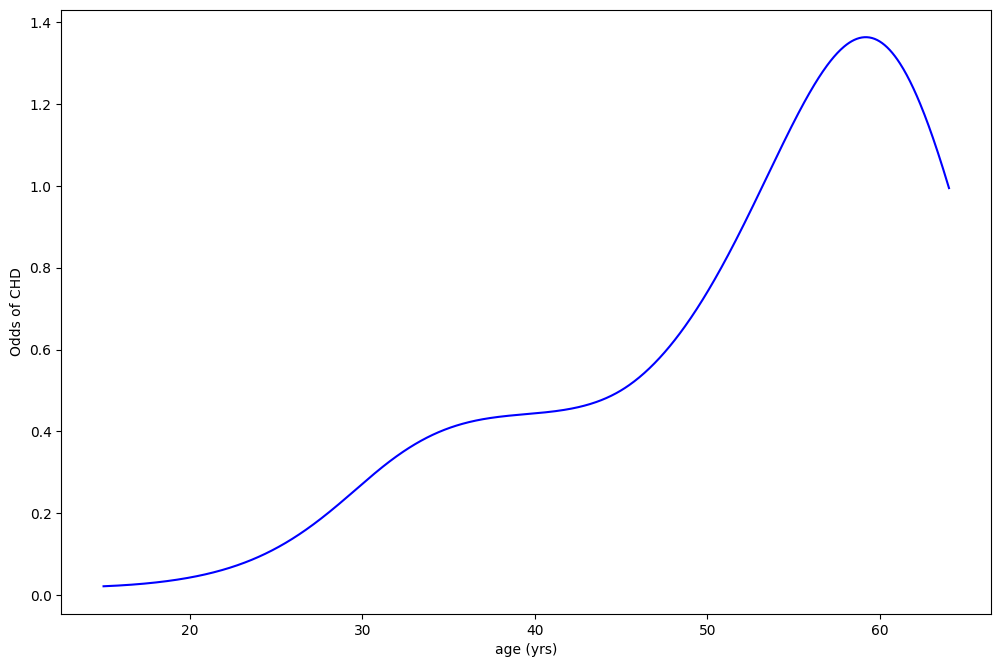

In [29]:
y = x_mat.dot(coefs).apply(np.exp)
plt.plot(x_col['age'], y, '-b')
plt.xlabel('age (yrs)')
plt.ylabel('Odds of CHD');

- Below is the probability scale
- Note: this can be miss leading because this is not a random sample of the population but a case control study
- Regardless, this scale is very intuitive because it gives an idea of the proportion of the data at each age experiencing CHD

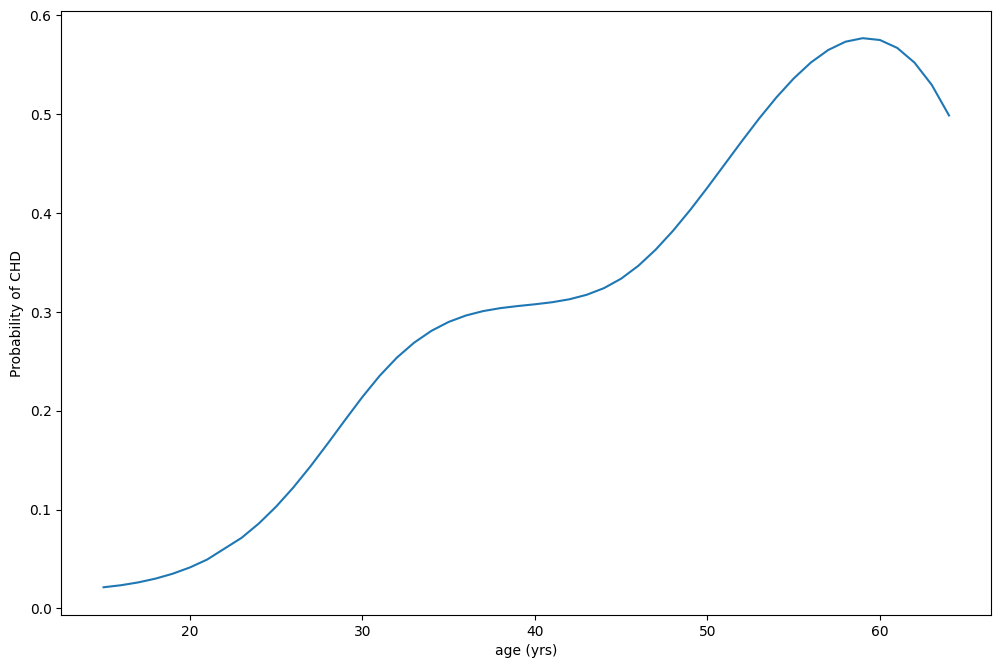

In [30]:
y = results.predict()
x,y = zip(*sorted(zip(dat['age'].tolist(), y)))
plt.plot(x,y)
plt.xlabel('age (yrs)')
plt.ylabel('Probability of CHD');

- Note: Logistic regression (before transformation) give log odds ratios
- Odds of event with probability $p$ is $\frac{p}{1-p}$
    - Odds of 1, or (1 to 1 odds) means there is a 50% chance
- Transforming with $\exp$ (including the intercept) give the odds of CHD at each age
- But, remember this dataset was a case-control study, not a general representation of the population so these odds are specific to this dataset

### Natural Splines

- Issues with regression spline models:
    - Polynomial functions can be erratic near the boundaries
    - And, for all models, extrapolation, predicting values outside of the domain of $x$ within the data, can easily lead to errors
    - These Problems can be worse with splines
- *Natural cubic spline* requires function to be linear beyond boundary knots
- This frees 4 degrees of freedom compared to cubic spline
- Drawback: potentially greater bias near boundary but this acceptable given that there is less information at boundaries
- Natural cubic splines with $K$ knots is represented by $K$ basis functions
$$
N_1(x)=1,\quad N_2(x)=x, \dots,\quad N_{k+2}(x) = d_k(x)-d_{K-1}(x)
$$
where
$$
d_k(x) = \frac{(x-\xi_k)_+^3-(x-\xi_K)_+^3}{\xi_K-\xi_k}
$$
- Note: number of knots = degrees of freedom for natural splines
- Each basis function has zero second and third derivatives
- Benefit: once all input variables have been transformed, can apply standard GLM theory

**Fitting Regression Splines**

- To fit regression splines, you need to choose the number of knots/basis functions and knot placement
- To determine the number of basis function, we could use AIC or some other fit metric
    - Note: some models (Likelihood ratio test, deviance) require nested model, AIC doesn't
    - What could go wrong with too many basis functions?
- For natural cubic splines, it's typical to place knots at uniform quantiles
    - e.g. with 3 knots, place each at 1st, 2nd, 3rd quartile
- Equal spacing of knots between max and min is sometimes done as well
- Another approach is to use model selection to select how many knots, removing knots that do not contribute to model fit
- This is a classic method, and can work well provided we choose good knots t1, . . . , tp; but in general choosing knots is a tricky business. There is a large literature on knot selection for regression splines via greedy methods like recursive partitioning (from statistical machine learning at Carnegie Mellon)

![](./overfit.png)

- Below is a visualization of natural cubic spline basis functions

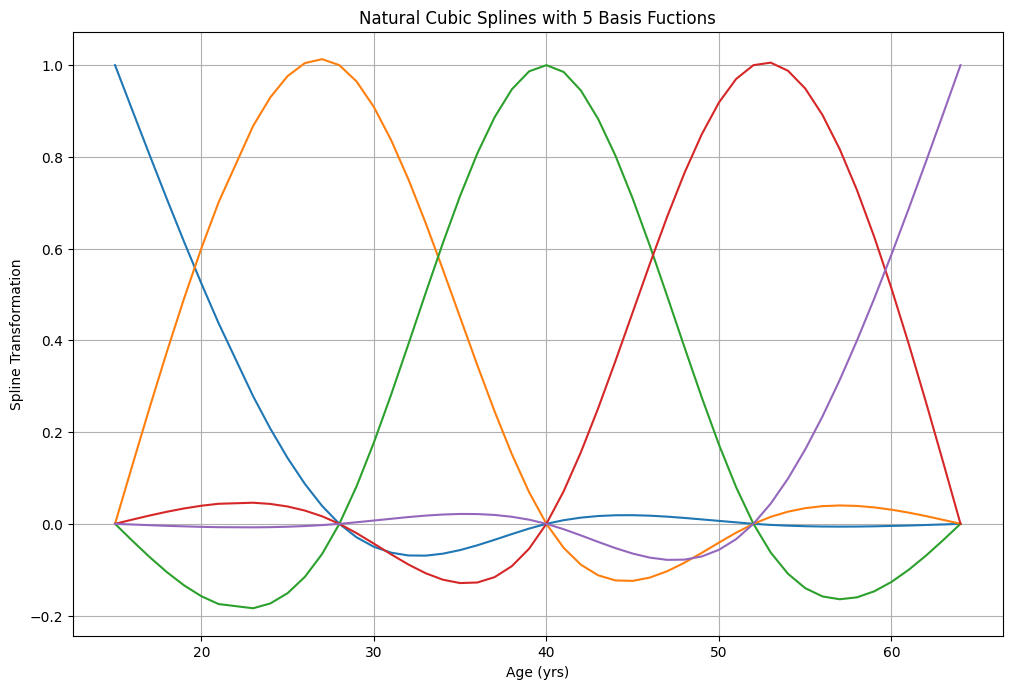

In [31]:
age = dat['age'].sort_values()
x_dmat = dmatrix("cr(age, 5)-1",
                 {"age": age}, return_type='dataframe')
plt.grid(True)
plt.plot(age, x_dmat)
plt.xlabel("Age (yrs)")
plt.ylabel("Spline Transformation")
plt.title("Natural Cubic Splines with 5 Basis Fuctions");

- The image below shows how a different number of knots/degrees of freedom affect the shape of the curve
- Notice that the curve for 3 knots fits better than the linear model using AIC as the fit metric

Linear Model AIC: 529.56


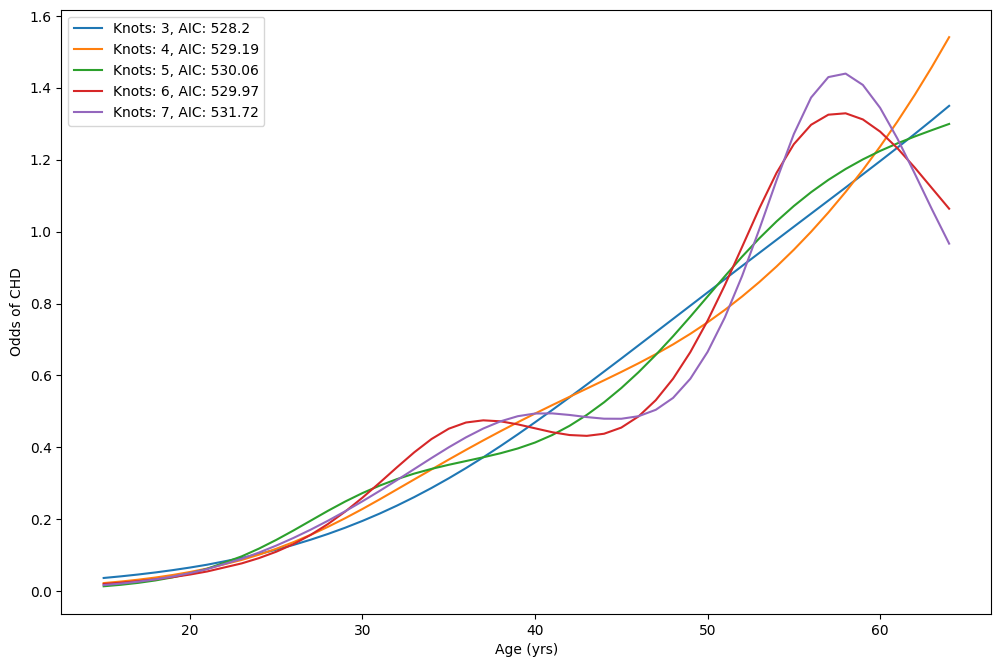

In [32]:
age_dat = sm.add_constant(dat['age'])
results = sm.Logit(dat.chd, age_dat).fit(disp=0)
print(f'Linear Model AIC: {np.round(results.aic, 2)}')

for num_knots in range(3,8):
    fmla = f"cr(age, {num_knots})"
    x_dmat = dmatrix(fmla, {"age": dat['age']})
    results = sm.Logit(dat.chd, x_dmat).fit(disp=0)
    y = np.exp(np.dot(x_dmat, results.params))
    x,y = zip(*sorted(zip(dat['age'].tolist(), y)))
    lab = f"Knots: {num_knots}, AIC: {np.round(results.aic, 2)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Odds of CHD')
plt.legend();

- I'm showing the model output below 
- In general, the `coef` values are must less useful than the associated graphic shown below the regression results

In [33]:
x_dmat = dmatrix("cr(age, 3)", {"age": dat['age']})
results = sm.Logit(dat.chd, x_dmat).fit(disp=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      459
Method:                           MLE   Df Model:                            2
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.1240
Time:                        16:15:08   Log-Likelihood:                -261.10
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.955e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9389   2.76e+06   -3.4e-07      1.000   -5.41e+06    5.41e+06
x1            -2.3607   2.76e+06  -8.56e-07      1.000   -5.41e+06    5.41e+06
x2             0.1833   2.76e+06   6.64e-08      1.000   -5.41e+06    5.41e+06
x3             1.2386   2.76e+06   4.49e-07      1.000   -5.41e+06    5.41e+06
==============================================================================
"""

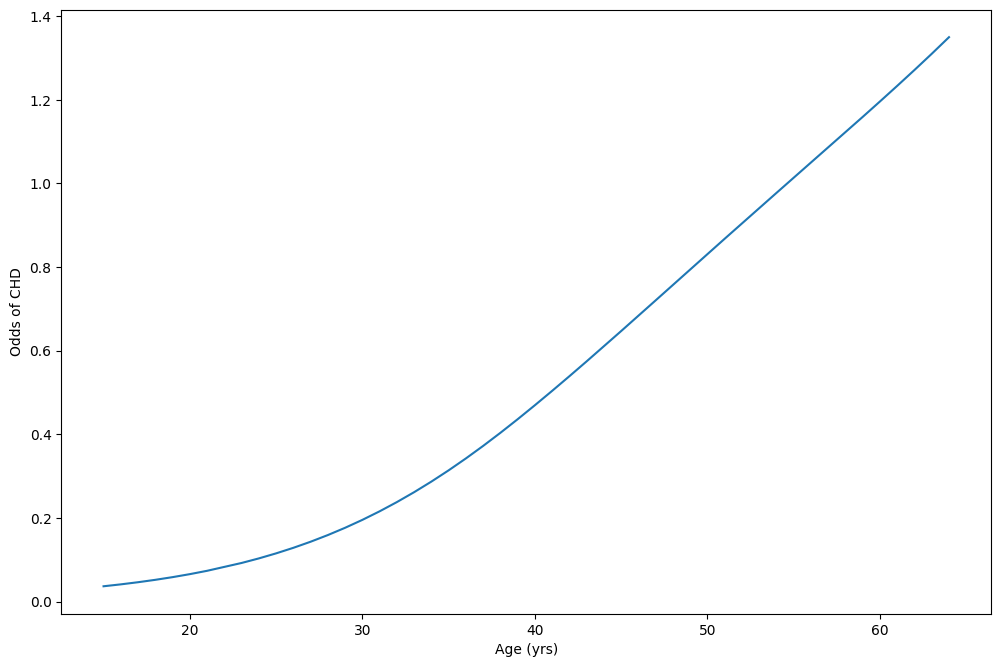

In [34]:
y = np.exp(np.dot(x_dmat, results.params))
x,y = zip(*sorted(zip(dat['age'].tolist(), y)))
plt.plot(x, y);
plt.xlabel('Age (yrs)')
plt.ylabel('Odds of CHD');

### Smoothing Splines

- Choosing knot locations can be tricky
- *Smoothing splines* circumvent this by placing knots at each input, $x_1, \dots, x_n$ while controlling overfitting by *regularization*
    - **Regularization** adds a penalty for model complexity
- Recall from linear regression, we want to minimize residual sum of squares (RSS):
$$
\text{RSS}(\beta) = \arg\min_\beta \sum_{i=1}^n \left(y_i-x^T\beta\right)^2
$$
where the regression function is $f(x)=x^T\beta$
- For smoothing splines, we want to minimize over all continuous functions with continuous first and second derivatives, plus a complexity term:
$$
\text{RSS}(f,\lambda) = \arg\min_f \sum_{i=1}^n \left[y_i-f(x_i)\right]^2 + \lambda\int[f''(t)]^2 dt
$$
where $\lambda\in(0,\infty)$ is a fixed smoothing parameter that is chosen beforehand
- If $\int[f''(t)]^2dt = 0$, then $f$ is linear
- If $\int[f''(t)]^2dt$ is large, then $f$ is very wiggly
- $\lambda=0 \Rightarrow f$ is any (wiggly) function that interpolates all points
- $\lambda=\infty \Rightarrow f$ is the least squares line from standard regression
- So far, this problem seems very difficult because it is not clear how to estimate $f$, which is assume to be in a *Sobolev function space*
- Remarkably, $f$, the solution to RSS$(f,\lambda)$, has a finite-dimensional (tractable) solution:
    - natural cubic spline with knots at each $x_i$:
    $$
    f(x) = \sum_{j=1}^n N_j(x)\theta_j
    $$
    where $N_j$ is the same as the natural basis function from above
- Once the transformation is done, RSS can be re-written:
$$
\text{RSS}(\theta, \lambda) = (y-N\theta)^T(y-N\theta)+\lambda\theta^T\Omega_N\theta
$$
where $\{N\}_{ij} = N_j(x_i)$ is a matrix ($j$th transformation of $i$ observation and $\Omega_N = \int N_j''(t)N_k''(t)dt$
- Solution:
$$
\hat \theta = (N^TN+\lambda\Omega_N)^{-1} N^Ty 
$$
- Fitted smoothing spline:
$$
\begin{align*}
\hat f(x) &= \sum_{j=1}^n N_j(x)\hat\theta_j\\
    &= N(N^TN+\lambda\Omega_N)^{-1}N^Ty \\
    &= S_\lambda y
\end{align*}
$$
- $S_\lambda$ is called the smoother matrix (similar to the hat matrix for linear regression)

**Choosing $\lambda$**

- Because smoothing splines place a knot at each distinct $x$ value, model degrees of freedom (and overfitting) are controlled by choice of $\lambda$
- Smoothing splines have many parameters (the number of distinct $x$ values but because of the penalty, these values are smaller than they would be without the penalty
- Because of this, we cannot talk about degrees of freedom in the same way as prior models, instead we use *effective degrees of freedom*
$$
\text{df}_\lambda = \text{trace}(S_\lambda)
$$
- Because of this change, it is better to fit the model using a *cross validation method*
- Cross validation shows how well a model fits on data it has never seen/used before
- We measure fit using mean squared error:
$$
E[y_i-\hat f(x_i)]^2
$$
- A good fit means that MSE is small
- Cross validation: use many different values of $\lambda$ and corresponding spline function, $f_\lambda$
$$
\hat f = \arg\min_{f_\lambda} \sum_{i=1}^n \left(y_i-f_\lambda(x_i)\right)^2
$$
- Leave-one-out cross validation (LOOCV):
$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^n \left[y_i-\hat f_\lambda^{(-i)}(x_i)\right]^2
$$
where $f^{(-i)}$ is a model that was estimated without using observation $i$
- $\hat f_\lambda^{(-i)}(x_i)$ is fast to compute
$$
\hat f_\lambda^{(-i)}(x_i) = \frac{\hat f_\lambda(x_i)-s_{\lambda,ii}y_i}{1-s_{\lambda,ii}}
$$
where $s_{\lambda,ii} = (S_\lambda)_{ii}$ is the $ii$ entry in the smoother matrix using all of the observations
- Using all of this, the we want to choose the $\lambda$ with best fit this way:
$$
\lambda^* = \arg\min_\lambda \sum_{i=1}^n \left(y_i-\hat f_\lambda^{(-1)}(x_i)\right)^2
=\arg\min_\lambda \sum_{i=1}^n \left(\frac{y_i-\hat f_\lambda(x_i)}{1-s_{\lambda,ii}}\right)^2
$$
- This is helpful because there is no need to refit the model each time

**Logistic Regression**

- Here, rather than minimize RSS, we use penalized log-likelihood:
$$
\begin{align*}
\ell(f;\lambda) &=\sum_{i=1}^n \left[y_i\log p(x_i)+(1-y_i)\log(1-p(x_i))\right]-\frac{\lambda}{2}\int[f''(t)]^2dt \\
    &= \sum_{i=1}^n \left[y_if(x_i)+\log(1+\exp(f(x_i))\right]-\frac{\lambda}{2}\int[f''(t)]^2dt
\end{align*}
$$
- This model can be optimized using gradient descent

**Smoothing Splines in Python and R**

- There is no clear smoothing spline function for logistic regression within a standard data science python module
    - `statsmodels` does not (as of now) have an explicit smoothing spline method
    - But, the `alpha` parameter in `statsmodels.gam` is list of penalization weights for each variable according to documentation
    - Might be possible to implement smoothing spline using this
    - `scipy.interpolate.UnivariateSpline` [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) indicate that it is a 1-D smoothing spline function for a continuous outcome; however, the `s`, smoothing factor parameter is used to chooses number of knots
    - It seems unclear how the spline is calculated without looking into the code
    - No clear way to extract smoother matrix to run LOOCV for `UniveriateSpline`
    - `CSAPS` may be a better alternative in python
- In R, `smooth.spline` is very close to the method described above, [documentation](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/smooth.spline)
    - `smooth.spline` makes it very easy to run cross validation
    - Does not implement logistic regression as shown above
    - Other R packages: `gam`, `mgcv`

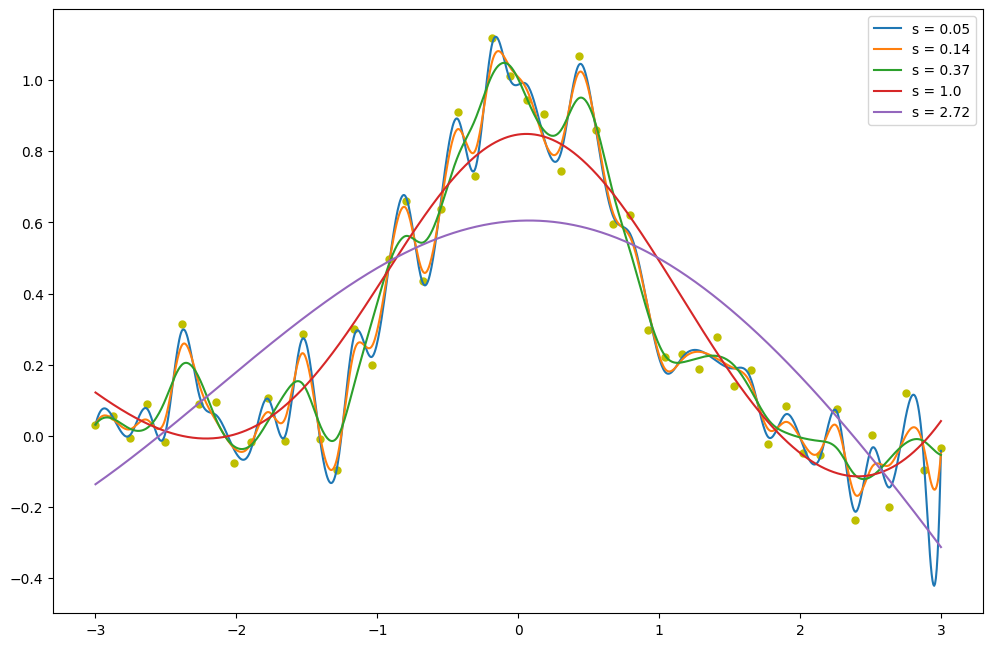

In [35]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
plt.plot(x, y, 'yo', ms=5)

spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)

for itr in range(5):
    sm_fact = np.exp(itr-3)
    spl.set_smoothing_factor(sm_fact)
    plt.plot(xs, spl(xs), label=f"s = {np.round(sm_fact, 2)}")
    plt.legend()


- The code below is an attempt to get `statsmodels` to run a smoothing spline
- Again, cross validation should be used when choosing $\lambda$ (alpha in the model)
- The `loocv` method below needs to be validated before professional use
- I would not recommend using this strategy in python until better smoothing spline methods arise
- Smoothing splines are very developed in R

Unique Ages: 49


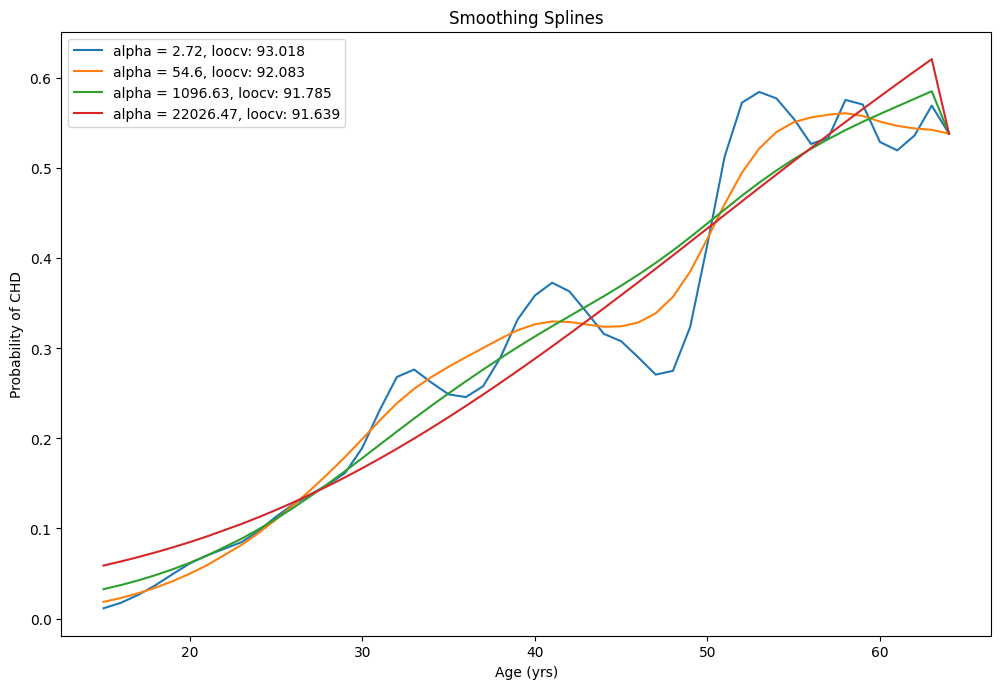

In [36]:
from statsmodels.gam.api import GLMGam

unique_ages = dat.age.nunique()
print(f"Unique Ages: {unique_ages}")

def loocv(results):
    resid = results.resid_response
    #resid = results.resid_deviance
    sii = results.hat_matrix_diag
    return(np.sum(np.square(np.divide(resid, 1-sii))))

for itr in range(4):
    sm_fact = np.exp(3*itr+1)
    fmla = f"chd ~ age"
    smoothing = sm.gam.BSplines(dat['age'], df = unique_ages, degree=3)
    model_smoothing = GLMGam.from_formula(
        fmla, data=dat, alpha = sm_fact, smoother=smoothing,
        family=sm.families.Binomial())
    results = model_smoothing.fit()
    
    x,y = zip(*sorted(zip(dat['age'].tolist(), results.predict())))
    lab = f"alpha = {np.round(sm_fact, 2)}, \
loocv: {np.round(loocv(results), 3)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Probability of CHD');
plt.title('Smoothing Splines')
plt.legend();

### B-Splines

- B-splines are a little more mathematically complex but computationally very fast because they are generated recursively
- Assume you choose $K$ knots within the domain of $x$: $\xi_1, \dots, \xi_K$ and you choose to use an order $M$ spline, then
- Let $\xi_0$ and $\xi_{K+1}$ be the boundary knots that to be the scalar domain for the spline function
- Let $\tau_1\leq\tau_2\leq \dots\leq\tau_M\leq\xi_0$
- Let $\tau_{j+M}=\xi_j, j=1,\dots,K$
- Let $\xi_{K+1}\leq \tau_{K+M+1}\leq\tau_{K+M+2}\leq \dots\leq\tau_{K+2M}$
- Denote $B_{i,m}(x)$ to be the $i$th B-spline basis function of order $m$ for the knot sequence $\tau, m\leq M$
$$
B_{i,1}(x) = \begin{cases}
1 \qquad \text{if } \tau_i\leq x<\tau_{i+1} \\
0 \qquad \text{otherwise}
\end{cases}
$$
for $i=1,\dots, K+2M-1$ and 
$$
B_{i,m} = \frac{x-\tau_i}{\tau_{i+m-1}-\tau_i}B_{i,m-1}(x)+\frac{\tau_{i+m}-x}{\tau_{i+m}-\tau_{i+1}}B_{i+1,m-1}(x)
$$
for $i=1,\dots, K+2M-m$

![](./bsplineESL.png)

Image from Elements of Statistical Learning

**B-splines in `statsmodels`**

- very easy to implement B-splines in `statsmodels`
- need to specify `df`, degrees of freedom/number of basis functions
- knots placed at quantiles by default but can also be specified
- 3rd order B-splines are most commonly used
    - seems unlikely to ever need higher than 3rd order
- There are multiple ways to run B-splines in `statsmodels`
- Below uses `R`-style formulas

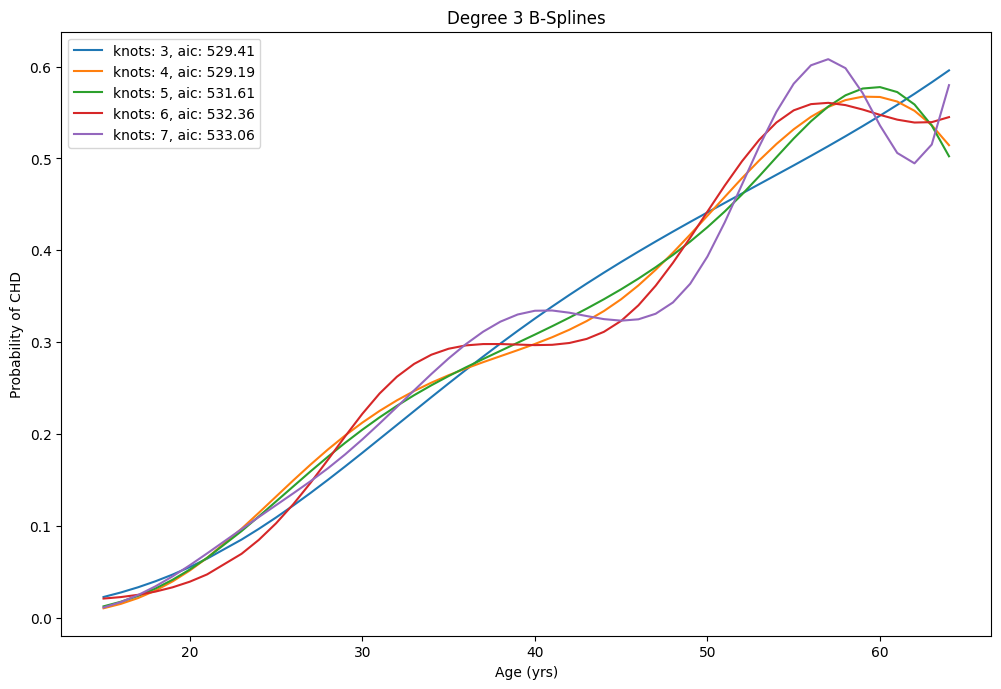

In [37]:
for knots in range(3,8):
    fmla = f"chd ~ bs(age, {knots})"
    modelBS = sm.GLM.from_formula(fmla, data=dat,
                                  family=sm.families.Binomial())
    results = modelBS.fit()
    x,y = zip(*sorted(zip(dat['age'].tolist(), results.predict())))
    lab = f"knots: {knots}, aic: {np.round(results.aic, 2)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Probability of CHD');
plt.title('Degree 3 B-Splines')
plt.legend();

### Interactions

- Interactions terms allow the joint values of two or more variables to be estimated separately
- If one variable is discrete, the interaction term allows for separate estimates each each value of the discrete variable
- Interactions can be included for two continuous variables as well
    - to visualize, must choose discrete values of one variable
- Similar to splines, including interaction terms allow for more model flexibility but uses an additional degree of freedom (parameter to estimate) for each interaction term

chd ~ bs(age, 4)*famhist AIC = 517.74
chd ~ age*famhist AIC = 514.07
chd ~ age+famhist AIC = 512.66


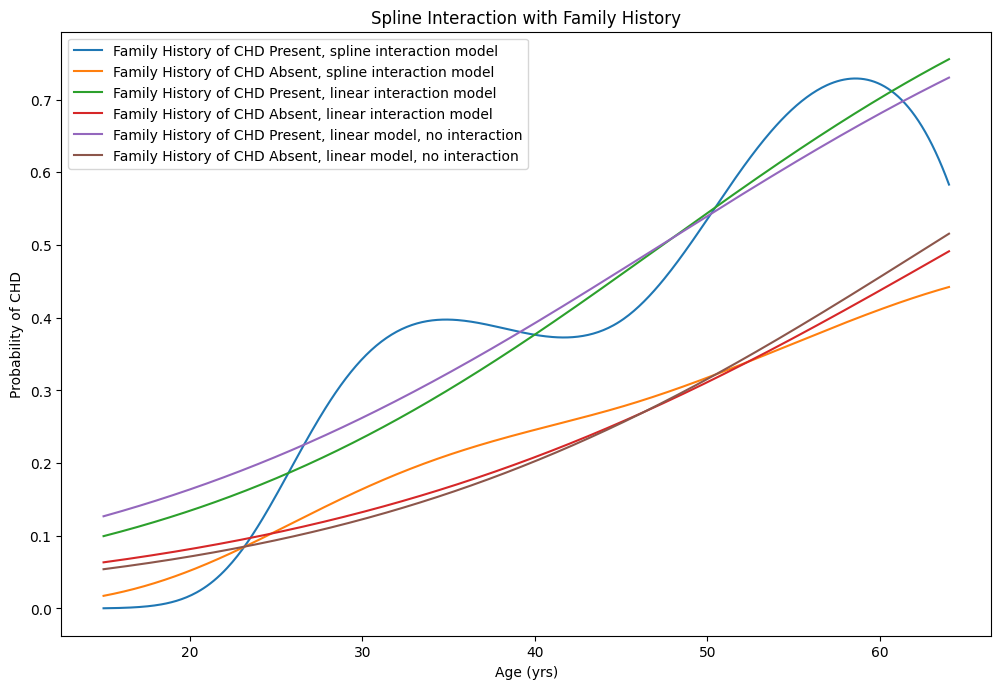

In [38]:
fmla = ("chd ~ bs(age, 4)*famhist", "chd ~ age*famhist",
        "chd ~ age+famhist")
num = 500
age = np.linspace(dat['age'].min(), dat['age'].max(), num)

for mod in range(3):
    modelBS = sm.GLM.from_formula(
        fmla[mod], data=dat, family=sm.families.Binomial())
    results = modelBS.fit()
    print(f"{fmla[mod]} AIC = {np.round(results.aic,2)}")
    for famhist in ('Present', 'Absent'):
        y = results.predict(
            pd.DataFrame({'age': age, 'famhist': famhist}))
        if mod==0:
            lab = f"Family History of CHD {famhist}, \
spline interaction model"
        elif mod==1:
            lab = f"Family History of CHD {famhist}, \
linear interaction model"
        else:
            lab = f"Family History of CHD {famhist}, \
linear model, no interaction"
        plt.plot(age, y, label=lab)
    plt.legend()
    plt.xlabel('Age (yrs)')
    plt.ylabel('Probability of CHD')
    plt.title('Spline Interaction with Family History');

### Model fitting with multiple variables: Generalized Additive Models (GAMs)

- Model structure:
$$
g(E[Y]) = \beta_0 + \beta_1 f_1(x_1) + \cdots + \beta_p f_p(x_p)
$$
where $f_j(x_j)$ is a vector valued function (each entry is the output of a basis function) with $\beta_j$ the corresponding parameter estimates

- There are many different schools of thought on model fitting
    - Choose simplest model with best fit
    - Data are never linear, if there is enough data, more complex models can capture non-linearity
    - In general, most tend to prefer simpler models
- Rule: after selecting between many different models using a dataset, the inference is no longer valid on the training data
- In general, GAM model selection is an area of active research
- Can be done with both smoothing splines and regression splines
- Here, we take a simple, forward-stepwise approach using AIC
- Challenge is that we must decide on smoothing level/number of knots for each variable

**Coding with GAMs**

- Note on `statsmodels`: The `gam` method that works fine for fitting the model, but prediction was an issue me
- The [documentation](https://www.statsmodels.org/stable/gam.html#examples) shows a prediction method but I was not able to get it to work
- Prediction for these models is super important because that is primarily what you use to how the relationship between the variables and outcome using plots
- Recommendation: use `sm.glm.from_formula` or `sm.ols.from_formula` with the `bs` operator to indicate that you want to use a spline
- Example `'chd ~ bs(sbp, 3)'` uses 3 knots (and an intercept), the default is to use degree=3
- `sm.gam.BSplines(sbp, df=4, degree=3)` gives the same spline model as above, `df=4` means 3 knots
- The code below could be improved with a function rather than repeating similar code each time

In [39]:
fmla = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'

vars = dat.columns.to_list()
vars.remove('famhist') # removing because categorical
vars.remove('chd')  # removing because response variable

model_aic = pd.DataFrame(columns=['Spline', 'DF', 'AIC'])

results = sm.GLM.from_formula(
    fmla, data=dat, family=sm.families.Binomial()).fit()
model_aic = model_aic.append(
        {'Spline': 'None', 'DF': None, 
         'AIC': results.aic}, ignore_index=True)

for knots in [4,5,6,7]:    
    for var in vars:
        smoothing = sm.gam.BSplines(dat[var], df=knots, degree=3)
        model_smoothing = GLMGam.from_formula(
            fmla, data=dat, smoother=smoothing,
            family=sm.families.Binomial())
        results = model_smoothing.fit()
        model_aic = model_aic.append(
            {'Spline': var, 'DF': knots, 'AIC': results.aic},
            ignore_index=True)

model_aic.sort_values(by='AIC')

,Spline,DF,AIC
4,obesity,4,497.101390
6,sbp,5,497.178477
0,None,None,497.192536
7,tobacco,5,497.318250
10,age,5,497.945123
5,age,4,498.349345
1,sbp,4,498.424468
9,obesity,5,498.744055
11,sbp,6,499.145155
16,sbp,7,499.650509


In [40]:
if 'obesity' in vars: vars.remove('obesity')
model_aic = pd.DataFrame(columns=['Spline', 'DF', 'AIC'])

for knots in [4,5,6,7]:    
    for var in vars:
        smoothing = sm.gam.BSplines(
            dat[[var, 'obesity']], df=[knots,4], degree=[3,3])
        model_smoothing = GLMGam.from_formula(
            fmla, data=dat, smoother=smoothing,
            family=sm.families.Binomial())
        results = model_smoothing.fit()
        model_aic = model_aic.append(
            {'Spline': var, 'DF': knots, 'AIC': results.aic},
            ignore_index=True)

model_aic.sort_values(by='AIC')

,Spline,DF,AIC
7,age,5,495.946758
3,age,4,496.765519
5,tobacco,5,496.808938
4,sbp,5,497.076777
15,age,7,497.174431
0,sbp,4,498.151899
11,age,6,498.653524
8,sbp,6,499.106552
12,sbp,7,499.258941
9,tobacco,6,499.284977


In [41]:
if 'age' in vars: vars.remove('age')
model_aic = pd.DataFrame(columns=['Spline', 'DF', 'AIC'])

for knots in [4,5,6,7]:    
    for var in vars:
        smoothing = sm.gam.BSplines(
            dat[[var, 'obesity','age']], df=[knots,4,5], degree=[3,3,3])
        model_smoothing = GLMGam.from_formula(
            fmla, data=dat, smoother=smoothing,
            family=sm.families.Binomial())
        results = model_smoothing.fit()
        model_aic = model_aic.append(
            {'Spline': var, 'DF': knots, 'AIC': results.aic},
            ignore_index=True)

model_aic.sort_values(by='AIC')

,Spline,DF,AIC
3,sbp,5,494.796009
6,sbp,6,496.432588
0,sbp,4,496.530683
9,sbp,7,497.544928
4,tobacco,5,498.180631
2,ldl,4,499.357585
1,tobacco,4,499.535596
8,ldl,6,500.398081
7,tobacco,6,500.438200
5,ldl,5,500.685028


In [42]:
if 'sbp' in vars: vars.remove('sbp')
model_aic = pd.DataFrame(columns=['Spline', 'DF', 'AIC'])

for knots in [4,5,6,7]:    
    for var in vars:
        smoothing = sm.gam.BSplines(
            dat[[var, 'obesity','age','sbp']], df=[knots,4,5,5],
            degree=[3,3,3,3])
        model_smoothing = GLMGam.from_formula(
            fmla, data=dat, smoother=smoothing,
            family=sm.families.Binomial())
        results = model_smoothing.fit()
        model_aic = model_aic.append(
            {'Spline': var, 'DF': knots, 'AIC': results.aic},
            ignore_index=True)

model_aic.sort_values(by='AIC')

,Spline,DF,AIC
2,tobacco,5,497.765758
1,ldl,4,498.243794
0,tobacco,4,498.469054
5,ldl,6,498.588094
3,ldl,5,499.376029
4,tobacco,6,499.562706
7,ldl,7,500.594051
6,tobacco,7,500.931839


- seeing if removing variables improves fit

In [43]:
smoothing = sm.gam.BSplines(
    dat[['obesity','age','sbp']], df=[4,5,5], degree=[3,3,3,3])

model_smoothing = GLMGam.from_formula(
    'chd ~ sbp + tobacco + famhist + obesity + age', 
    data=dat, smoother=smoothing, family=sm.families.Binomial())
print(f"Removing ldl, aic: {np.round(model_smoothing.fit().aic,2)}")
model_smoothing = GLMGam.from_formula(
    'chd ~ sbp + ldl + famhist + obesity + age', 
    data=dat, smoother=smoothing, family=sm.families.Binomial())
print(f"Removing tobacco, aic: {np.round(model_smoothing.fit().aic)}")
model_smoothing = GLMGam.from_formula(
    'chd ~ sbp + tobacco + ldl + obesity + age', 
    data=dat, smoother=smoothing, family=sm.families.Binomial())
print(f"Removing famhist, aic: {np.round(model_smoothing.fit().aic,2)}")

Removing ldl, aic: 506.37
Removing tobacco, aic: 503.0
Removing famhist, aic: 512.81


- removing these makes model fit worse, so we keep them
- the final model for the forward step-wise approach is below
- showing graphics for these is very important because the parameter numbers or very difficult to interpret compared to the spline function

GLMGam, aic: 494.8
GLM, aic: 494.8


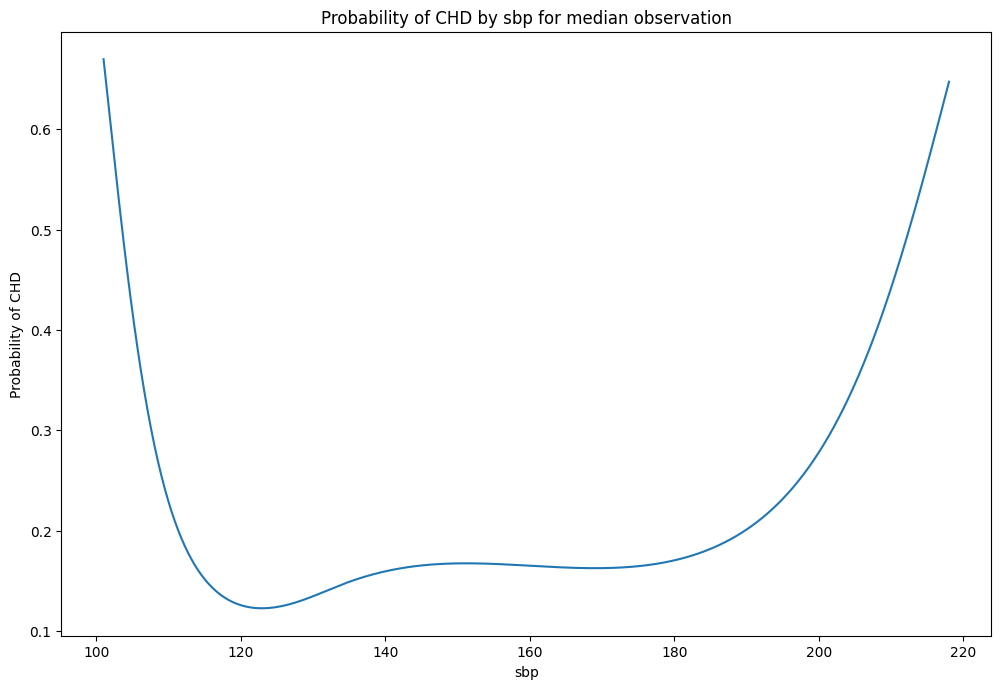

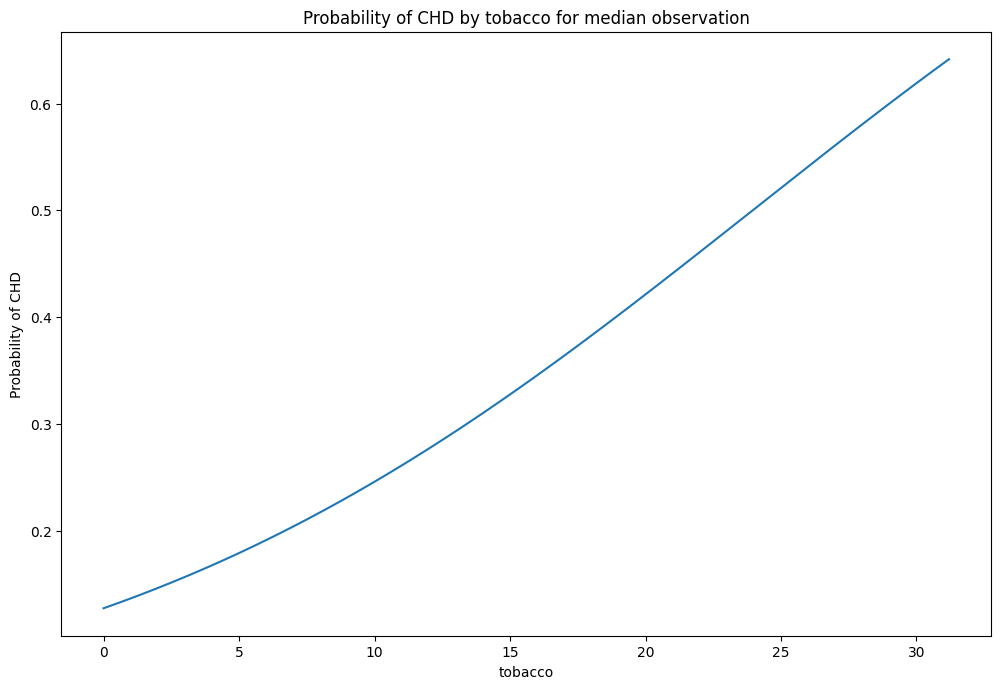

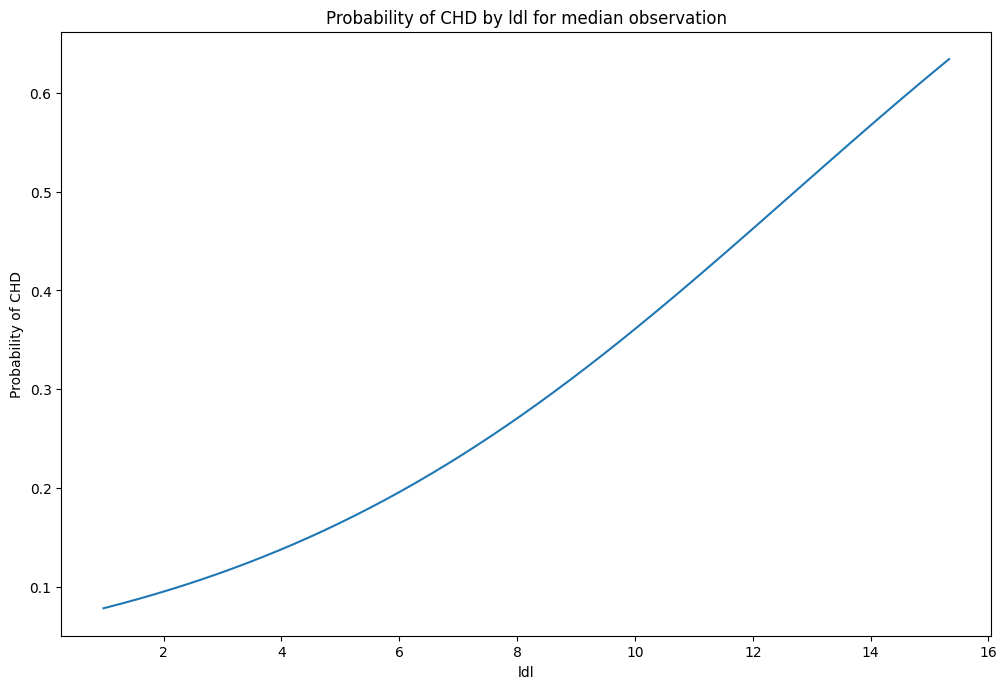

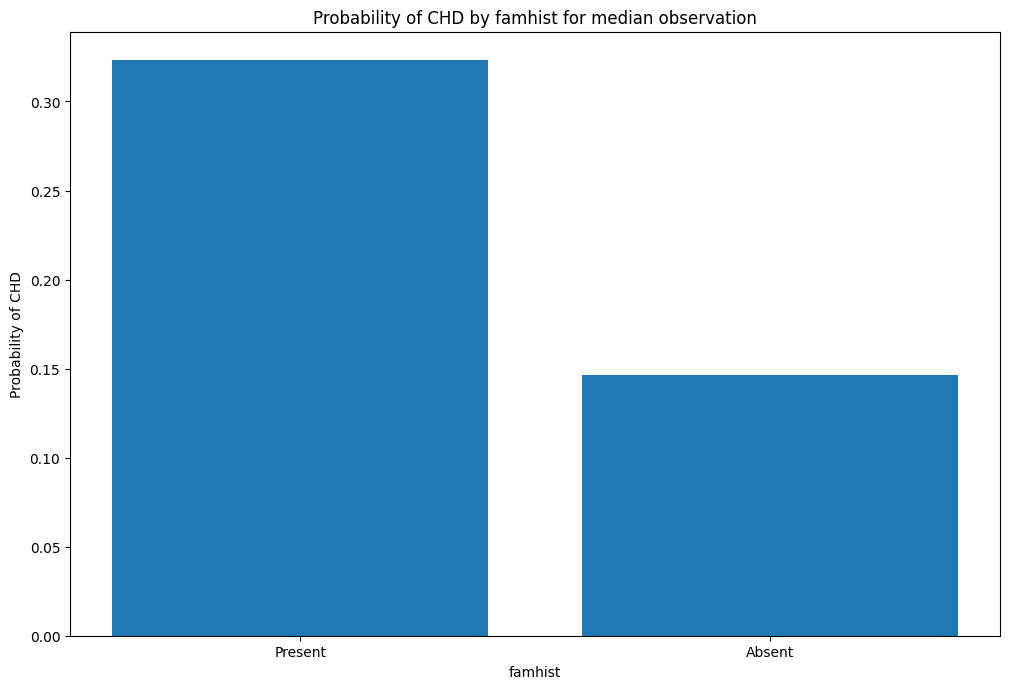

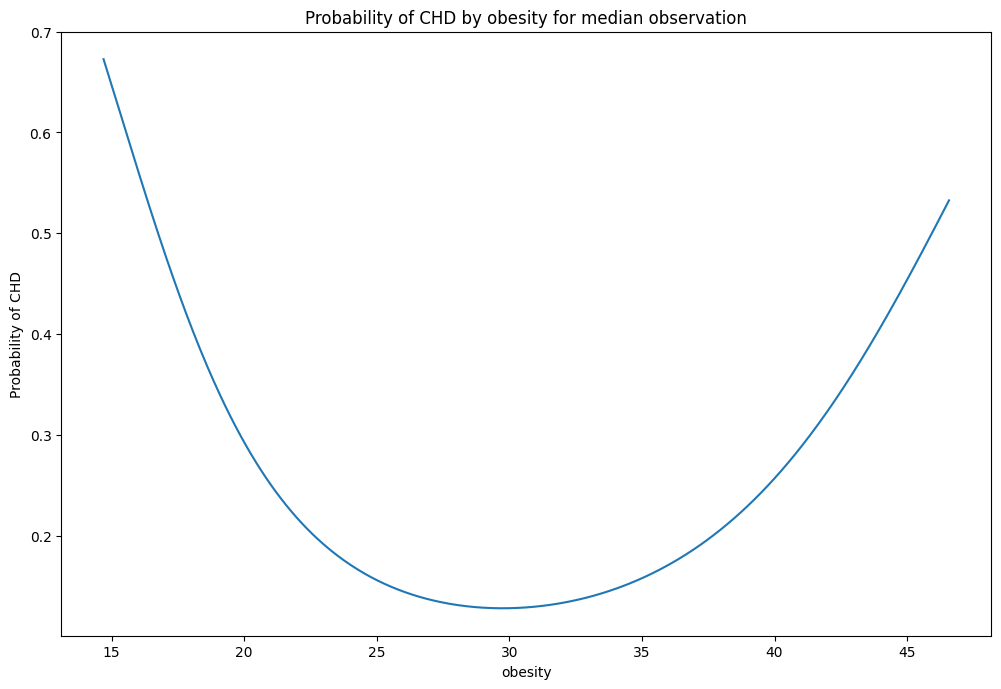

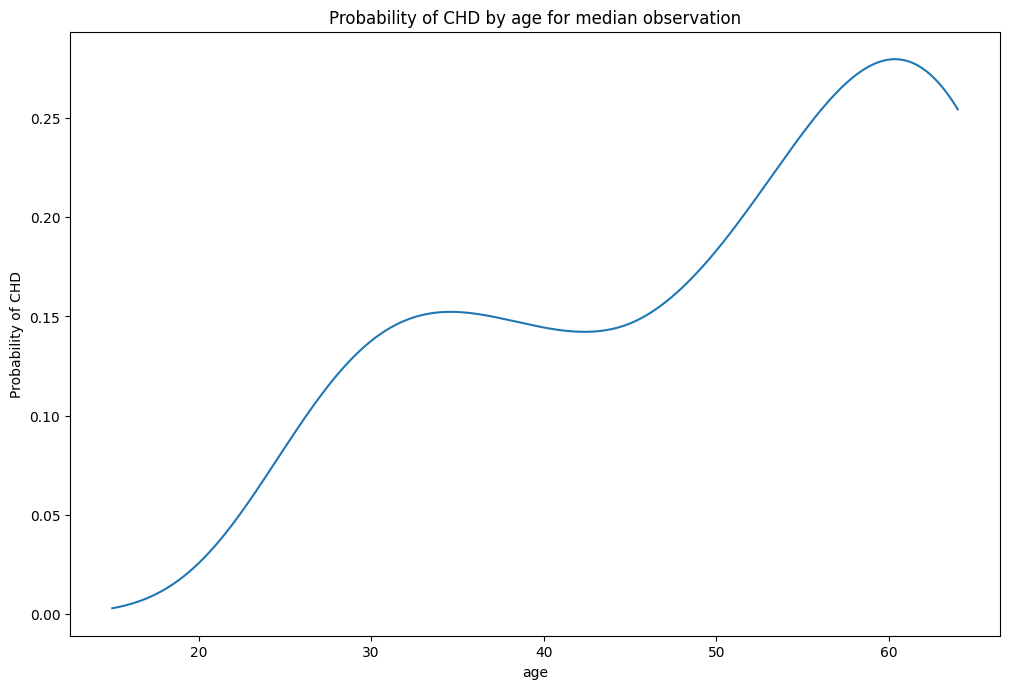

In [44]:
fmla = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'
smoothing = sm.gam.BSplines(
    dat[['obesity','age','sbp']], df=[4,5,5], degree=[3,3,3])
fsw_model = GLMGam.from_formula(
    fmla, data=dat, smoother=smoothing, family=sm.families.Binomial())
fsw_results = fsw_model.fit()
print(f"GLMGam, aic: {np.round(fsw_results.aic,2)}")

fmla = 'chd~bs(sbp,4)+tobacco+ldl+famhist+bs(obesity,3)+bs(age,4)'
fsw_model = sm.GLM.from_formula(
    fmla, data=dat, family=sm.families.Binomial())
fsw_results = fsw_model.fit()
print(f"GLM, aic: {np.round(fsw_results.aic,2)}")


vars = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']

def get_median_mode(vars, num):
    d_mat = {}
    for var in vars:
        if np.issubdtype(dat[var].dtype, np.number):
            d_mat[var] = dat[var].median()
        else:
            d_mat[var] = dat[var].mode()
    d_mat = pd.DataFrame(d_mat)
    return(sm.add_constant(pd.concat([d_mat]*num)))

def plot_spline(var):
    if np.issubdtype(dat[var].dtype, np.number):
        num = 500
        d_mat = get_median_mode(dat, num)
        d_mat[var] = np.linspace(dat[var].min(), dat[var].max(), num)
        y = fsw_results.predict(exog = d_mat)
        plt.plot(d_mat[var], y)
    else:
        d_mat = get_median_mode(dat, dat[var].nunique())
        d_mat[var] = dat[var].unique()
        y = fsw_results.predict(exog = d_mat)
        plt.bar(d_mat[var], y)
    plt.xlabel(var)
    plt.ylabel('Probability of CHD')
    plt.title(f'Probability of CHD by {var} for median observation')

for var in vars:
    plt.figure()
    plot_spline(var)

- How do the estimates above compare to the original linear logistic model?
- Results explanation example for obesity: Figure [figure number] provides the model expected probability of CHD from the data by obesity (BMI) for median values of age, LDL, and all other variables used in the model.  The U-shape of the curve indicates that those with the least and greatest BMI, at the time the survey was taken, had the greatest risk of CHD while those with a BMI closer to the center tended to have a lower risk of CHD.  This finding is counterintuitive and may be due, in part, to the fact that for this case-control study, BMI was taken at the time of the survey, rather than at the time of CHD.  The lower BMI may actually have been a result of CHD, as CHD patients are encouraged to lower their BMI.  This U-shaped relationship is missed when using a model that assumed linear relationships, see model [model number] in appendix.
- It is not necessary to explain each plot
    - explaining the plots with different shapes is probably sufficient because the reader can infer meaning for similar plots
- Presentation tip: use a grid to present these figures
    - This way the reader can take in more information at once
    - If $x$-axes were on the same scale, I would have plotted them together
    - In general, you want to hit a balance between too much and too little graphical information
- These effects at first may come as a surprise, but an explanation lies in the nature of the retrospective data. These measurements were made sometime after the patients suffered a heart attack, and in many cases they had already benefited from a healthier diet and lifestyle, hence the apparent increase in risk at low values for obesity and sbp. (from ESL)
- How to make a single prediction below

In [45]:
value =  {'sbp': 134, 'tobacco': 2, 'ldl': 4.34,
     'famhist': 'Absent', 'obesity': 25.805, 'age': 45}
fsw_results.predict(value)

0    0.146415
dtype: float64

In [46]:
fsw_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      447
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -232.40
Date:                Thu, 04 Mar 2021   Deviance:                       464.80
Time:                        16:15:13   Pearson chi2:                     475.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.9651      1.876     -1.048      0.295      -5.641       1.711
famhist[T.Present]     1.0231      0.232      4.409      0.000       0.568       1.478
bs(sbp, 4)[0]         -3.3098      1.550     -2.136      0.033      -6.347      -0.272
bs(sbp, 4)[1]         -1.1994      1.155     -1.039      0.299      -3.463       1.064
bs(sbp, 4)[2]         -3.4963      2.019     -1.732      0.083      -7.454       0.461
bs(sbp, 4)[3]         -0.1001      1.550     -0.065      0.949      -3.138       2.938
tobacco                0.0803      0.027      3.017      0.003       0.028       0.132
ldl                    0.2106      0.059      3.572      0.000       0.095       0.326
bs(obesity, 3)[0]     -4.0650      3.108     -1.308      0.191     -10.156       2.026
bs(obesity, 3)[1]     -2.7604      1.630     -1.693      0.090      -5.956       0.435
bs(obesity, 3)[2]     -0.5900      2.769     -0.213      0.831      -6.016       4.836
bs(age, 4)[0]          5.5310      2.160      2.561      0.010       1.298       9.764
bs(age, 4)[1]          2.7024      1.292      2.091      0.037       0.170       5.235
bs(age, 4)[2]          5.2463      1.583      3.314      0.001       2.144       8.349
bs(age, 4)[3]          4.7688      1.387      3.438      0.001       2.050       7.488
======================================================================================
"""

- Looking for interactions
- Below we look for interactions with `famhist`
- You can also look for interactions with spline basis functions as well
- these are sometimes called *tensor products*

In [47]:
fmla_list = [
    'chd~bs(sbp,4)+tobacco+ldl+famhist+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)*famhist+tobacco+ldl+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco*famhist+ldl+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)*famhist+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)+bs(age,4)*famhist'
]
for fmla in fmla_list:
    fsw_model = sm.GLM.from_formula(
        fmla, data=dat, family=sm.families.Binomial())
    fsw_results = fsw_model.fit()
    print(f"{fmla}, aic: {np.round(fsw_results.aic,2)}")

chd~bs(sbp,4)+tobacco+ldl+famhist+bs(obesity,3)+bs(age,4), aic: 494.8
chd~bs(sbp,4)*famhist+tobacco+ldl+bs(obesity,3)+bs(age,4), aic: 498.99
chd~bs(sbp,4)+tobacco*famhist+ldl+bs(obesity,3)+bs(age,4), aic: 495.68
chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4), aic: 488.05
chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)*famhist+bs(age,4), aic: 500.36
chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)+bs(age,4)*famhist, aic: 496.0


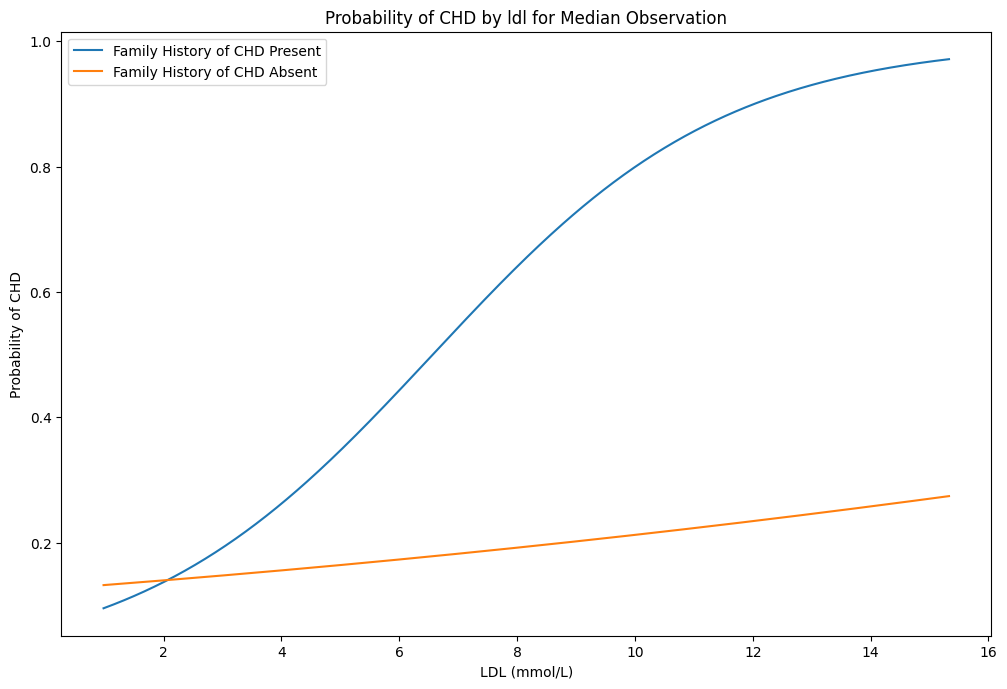

In [48]:
fmla = 'chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4)'
fsw_model = sm.GLM.from_formula(
        fmla, data=dat, family=sm.families.Binomial())
fsw_results = fsw_model.fit()

num = 500
var = 'ldl'
for famhist in ['Present', 'Absent']:
    d_mat = get_median_mode(dat, num)
    d_mat['famhist'] = famhist
    d_mat[var] = np.linspace(dat[var].min(), dat[var].max(), num)
    y = fsw_results.predict(exog = d_mat)
    plt.plot(d_mat[var], y, label = f'Family History of CHD {famhist}')
plt.xlabel('LDL (mmol/L)')
plt.ylabel('Probability of CHD')
plt.title(f'Probability of CHD by {var} for Median Observation')
plt.legend();


**Smoothing Spline GAMs**

- This is an easier approach to generalized additive model selection because a machine can quickly evaluate many penalty hyper-parameters then choose the best model based on some fit criteria such as LOOCV, CV, or other criteria like [restricted maximum likelihood](https://en.wikipedia.org/wiki/Restricted_maximum_likelihood) (REML)
- Again, for GAMs,
$$g(E[Y|X=x]) = \sum_{j=1}^p f_j(x_j)$$
- Smoothing splines optimize each $f_j$ with a penalty
$$\hat f_1, \dots, \hat f_p = \arg\min_{f_1,\dots, f_p} \ell(y; f_1,\dots, f_p)+\sum_{j=1}^p \lambda_j\int [f_j''(t)]^2dt$$ where $\ell$ is log-likelihood
- In this optimization, the strongest penalty ($\lambda_j=\infty$) results with $f_j$ being a linear function
- The penalty can be modified to determine remove a variable entirely for the model if it does not contribute to better model fit, [paper](https://web.stanford.edu/~hastie/Papers/gamsel.pdf)
- `pygam` is a smoothing spline approach (uses regularization)
- Below is my attempt to use smoothing spline in python with [pygam](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints), unfortunately, I didn't get it working
- For now, I would recommend using R for smoothing spline GAM selection
- More generally, it is much faster (automatic) to fit GAMs with smoothing splines rather than the stepwise approach with regression splines
- This [article](https://multithreaded.stitchfix.com/blog/2015/07/30/gam/) describes GAMs at a high level and shows how to implement in R with [mgcv](https://cran.r-project.org/web/packages/mgcv/index.html)

In [49]:
import pygam
X = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']].copy()
X['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)

gam = pygam.GAM(pygam.s(0)+pygam.s(1)+pygam.s(2)+pygam.f(3)+
                pygam.s(4)+pygam.s(5), 
                distribution='binomial', link='log').fit(X, dat['chd'])


/Users/roctavio/Documents/umich/statConsulting/env/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: invalid value encountered in power
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/Users/roctavio/Documents/umich/statConsulting/env/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: divide by zero encountered in power
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


did not converge


/Users/roctavio/Documents/umich/statConsulting/env/lib/python3.9/site-packages/pygam/utils.py:725: RuntimeWarning: invalid value encountered in log
  out[mask] = y[mask] * np.log(y[mask] / u[mask])


### Splines in practice

- Use a model that you understand well enough
    - this is very important when speaking with a client, that you are knowledgeable
- Use a model that easy enough to implement (code)
    - This may change depending on the language you work in
    - for example, I would probably only use a smoothing spline in R
- Overfitting should always be a concern with splines
- Cross validation is the gold standard to avoid over/underfitting but splits data
- AIC is a good runner up in likelihood-based models with easy parameter counts, uses all data
- Splines can be used for interpretation and prediction
    - if accurate prediction is important, cross validation is better than AIC
    - AIC uses the data twice, once to fit and again to evaluate
    - Cross validation avoids this
- Present splines models with graphics
    - Be aware that spline plots choose a fixed value of each model parameter for a spline curve
    - You may want to present more than one value to illustrate how a curve will shift upward or downward depending on the values chosen
    
### Homework Grading Rubric

- Professional
    - language, grammar
    - tables well-formatter, reasonable number
    - helpful, interesting graphics
    - uses headings
    - meets client's needs
    - could use as job interview material
- Intro
    - First sentence is easy to understand and address the subject matter topic
    - Problem and purpose of report is clearly stated
    - Does not use statistical jargon
    - (sometimes) summarize high level findings
- Methods
    - Connects problem, data, and modeling
    - Uses appropriate level of detail for audience
    - Describe statistical model
    - Describe model selection approach
    - shows understanding of possible data nuance (eg including an outcome in a model or repeated information)
- Results
    - Includes a description of the data
    - Describes variables
        - Most of the time, this will require a table
        - For data with a lot of variables, you may need to put table in appendix or skip entirely
    - Variables are explained when initially presented
    - Explains model/parameters in terms of the subject matter
    - Includes a reasonable number of graphics
         - should be well chosen
         - axes must be labels
         - graphic should contain an appropriate amount of information
         - clearly related to topic
         - has a description
    - Modeling
         - presented in a reasonable way given the model (either table or with graphics
         - appropriate for client's needs
         - well explained (eg GLM log parameters exponentiated)
         - Reasonable overall fit with consideration of complexity
- Conclusion
    - Discusses actual and potential limitation
    - Connects results with overall purpose
- Code appendix
    - does not show unhelpful computer output (especially very long output)
    - uses sentences to describe what does is doing and sometimes why
    - Gives granular description of data with tables and plots (these do not need to be perfectly formatted)
    - Looks for issues with data, outliers, influential points etc
    - Includes model diagnostics
    - If you are proving usable code, always include documentation with an example of how to use it
    

### Non-parametric Regression

- Assume $(X,Y)\in \mathbb{R}^d\times\mathbb{R}$ is a random vector
- Regression function
$$
f_0(x)=\mathbb{E}[Y|X=x]
$$
- Goal: estimate $f_0$ from a model $\hat f$ using observation $(X_i,Y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$
- If the sample, $(x_i,y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$, is identically, independently distributed (i.i.d.), we generally write
$$
y_i=f_0(x_i)+\epsilon_i
$$
where $\epsilon_i$ is random error with $\mathbb{E}[\epsilon_i]=0$ and $\epsilon_i$ is independent of $x_i$
- In most non-parametric regression settings, it is common to assume that $f_0$ is more complex than a linear function (dot product) of $x_i$ and parameters $\beta$
- But, $f_0$ is almost always assumed to be in some class of functions - For example, we could assume that $f_0$ is an $r$-degree polynomial or that $f_0$ is any function where all $k$th-order partial derivatives are bounded by $L<\infty$
- Fit is generally quantified with the $L_2$ function norm $\|\cdot\|_2$
$$
\|\hat f-f_0\|_2^2=\mathbb{E}\left[(\hat f(x)-f_0(x))^2\right]=\int[\hat f(X)-f_0(X)]^2 p(x)dx
$$
- For a random sample, $(x_i,y_i)\in\mathbb{R}^d\times\mathbb{R}$ for $i=1,\dots,n$, this translates to mean squared error (MSE)
$$
\text{MSE}=\frac{1}{n}\sum_{i=1}^n [\hat f(x_i)-f_0(x_i)]^2 = \frac{1}{n}\sum_{i=1}^n [\hat f(x_i)-y_i]^2
$$

Notes based on [Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. The elements of statistical learning. Vol. 1. No. 10. New York: Springer series in statistics, 2001.](http://statweb.stanford.edu/~tibs/book/preface.ps)